# Atlas 14 Comprehensive Workflow - Multi-Method Storm Suite

## Purpose

This notebook demonstrates a **complete end-to-end workflow** for generating and running multiple Atlas 14 storm scenarios using **hydrograph boundary conditions** with all available precipitation methods.

**Scope**: Hydrograph boundary conditions (not gridded precipitation)

**For gridded precipitation workflows**, see future notebooks on gridded Atlas 14 storms.

## Workflow Overview

1. **Project Setup** - Extract RasExamples project as template
2. **Storm Generation** - Generate comprehensive Atlas 14 storm suite using all methods
3. **Project Cloning** - Clone project copies for each storm scenario
4. **Bulk Execution** - Execute all HEC-RAS plans (optional)
5. **Results Comparison** - Extract and compare results across all storm types

## Storm Suite Composition

For each AEP (10-year, 50-year, 100-year), this workflow generates:

| Method | Variants | HMS-Equiv | Total per AEP |
|--------|----------|-----------|---------------|
| **Atlas14Storm** | 5 quartiles (First, Second, Third, Fourth, All Cases) | YES | 5 |
| **ScsTypeStorm** | 4 types (I, IA, II, III) | YES | 4 |
| **StormGenerator** | Centered peak (50%) | NO | 1 |

**Total storms per AEP**: 10
**Total storms for 3 AEPs**: 30

**Note**: All methods use the **same Atlas 14 total depth** for fair comparison. StormGenerator is included to demonstrate the Alternating Block Method temporal pattern as an alternative to HMS-equivalent patterns.

## Prerequisites

- **HEC-RAS 6.5+** installed (for plan execution)
- **hms-commander** package (for HMS-equivalent methods)
- **~5GB disk space** for cloned projects
- **Significant compute time** if executing all plans

## Related Notebooks

- `720_precipitation_methods_comprehensive.ipynb` - Method comparison (no execution)
- `725_atlas14_spatial_variance.ipynb` - Spatial variance analysis
- `110_single_plan_execution.ipynb` - Single plan execution basics

---

## Part 1: Setup and Imports

DEV NOTES: 

This notebook should focus on Atlas 14 Gridded Precipitation demonstration, and should include a comparison with the spatially nonvarying run (directly compare mesh cells, and show the difference in max WSEL across the mesh in a figure)

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = True  # Set to True for local development, False for pip package

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander core
from ras_commander import (
    RasExamples, 
    init_ras_project, 
    ras,
    RasCmdr, 
    RasPlan,
    RasPrj
)
from ras_commander.hdf import HdfResultsPlan, HdfMesh

# Import precipitation modules
from ras_commander.precip import (
    StormGenerator,                # Alternating Block Method (for comparison)
    Atlas14Storm,                  # HMS-equivalent Atlas 14 temporal distributions
    ScsTypeStorm,                  # HMS-equivalent SCS Type I/IA/II/III
    ATLAS14_AVAILABLE,             # Availability flag for Atlas14Storm
    SCS_TYPE_AVAILABLE             # Availability flag for ScsTypeStorm
)

import ras_commander
print(f"Loaded ras_commander: {ras_commander.__file__}")

# Check method availability
print(f"\nMethod Availability:")
print(f"  Atlas14Storm (HMS-equiv): {'[OK]' if ATLAS14_AVAILABLE else '[--]'}")
print(f"  ScsTypeStorm (HMS-equiv): {'[OK]' if SCS_TYPE_AVAILABLE else '[--]'}")
print(f"  StormGenerator (Alternating Block): [OK]")

if not (ATLAS14_AVAILABLE and SCS_TYPE_AVAILABLE):
    print("\n  Install hms-commander for HMS-equivalent methods:")
    print("  pip install hms-commander")

LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
Loaded ras_commander: c:\GH\ras-commander\ras_commander\__init__.py

Method Availability:
  Atlas14Storm (HMS-equiv): [OK]
  ScsTypeStorm (HMS-equiv): [OK]
  StormGenerator (Alternating Block): [OK]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import shutil
import time

# Configure output
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Standard libraries imported successfully")

Standard libraries imported successfully


### Configuration Parameters

Customize these values for your project and location.

In [3]:
# =============================================================================
# CONFIGURATION - Edit these for your project
# =============================================================================

# Project Configuration
PROJECT_NAME = "Davis"             # Example project (hydrograph BC)
RAS_VERSION = "6.6"               # HEC-RAS version
TEMPLATE_PLAN = "02"              # Plan to use as template (Davis has plan 02)

# Location for Atlas 14 precipitation
# Using Houston, TX for Atlas 14 (Texas has full multi-duration support)
LATITUDE = 29.76
LONGITUDE = -95.37


### QAQC COMMENT:  ARE THE STATE AND REGION USED? 


STATE = "tx"                      # Texas
REGION = 3                        # Atlas 14 Region 3 for TX (Houston area)

# Storm Parameters
STORM_DURATION_HOURS = 24         # 24-hour storm
TIME_INTERVAL_MIN = 60            # 1-hour intervals for output

# AEP Suite (Annual Exceedance Probabilities)
# Depths from NOAA Atlas 14 PFDS for Houston, TX
AEP_SUITE = {
    '10yr': {'aep_percent': 10.0, 'depth_inches': 6.94},   # 10-year event
    '50yr': {'aep_percent': 2.0,  'depth_inches': 11.60},  # 50-year event
    '100yr': {'aep_percent': 1.0, 'depth_inches': 17.0},   # 100-year event
}

# Execution Control
# WARNING: Setting to True will execute HEC-RAS for 30 scenarios
# This can take HOURS depending on model complexity!
EXECUTE_PLANS = True             # Set to True to run HEC-RAS
NUM_CORES = 2                     # CPU cores per execution
MAX_PARALLEL_WORKERS = 4          # Concurrent executions (if using parallel)

# Working Directory
WORKING_DIR = Path("example_projects") / "atlas14_workflow"

print("Configuration Summary:")
print(f"  Project: {PROJECT_NAME}")
print(f"  Location: ({LATITUDE}, {LONGITUDE}) - {STATE.upper()}")
print(f"  Storm Duration: {STORM_DURATION_HOURS} hours")
print(f"  AEP Events: {list(AEP_SUITE.keys())}")
print(f"  Execute Plans: {EXECUTE_PLANS}")
print(f"\n  Total storms to generate: {len(AEP_SUITE) * 10}  (10 storms per AEP)")
print(f"    - Atlas14Storm: 5 quartiles (HMS-equivalent)")
print(f"    - ScsTypeStorm: 4 types (HMS-equivalent)")
print(f"    - StormGenerator: 1 variant (Alternating Block, NOT HMS-equivalent)")
if EXECUTE_PLANS:
    print(f"\n  WARNING: Plan execution enabled - this will take significant time!")

Configuration Summary:
  Project: Davis
  Location: (29.76, -95.37) - TX
  Storm Duration: 24 hours
  AEP Events: ['10yr', '50yr', '100yr']
  Execute Plans: True

  Total storms to generate: 30  (10 storms per AEP)
    - Atlas14Storm: 5 quartiles (HMS-equivalent)
    - ScsTypeStorm: 4 types (HMS-equivalent)
    - StormGenerator: 1 variant (Alternating Block, NOT HMS-equivalent)



---

## Part 1: Project Setup

Extract the Davis example project (hydrograph boundary conditions) and initialize it as our template.

**Note**: This project uses hydrograph boundary conditions. For gridded precipitation examples, use BaldEagleCrkMulti2D with Plan 06.

In [4]:
# =============================================================================
# 1.1 Extract Example Project
# =============================================================================
print("Extracting example project...")

try:
    # Extract with suffix to organize cloned models
    template_path = RasExamples.extract_project(PROJECT_NAME, suffix="_721_Rainfall_Comparison_Models")
    print(f"[OK] Extracted to: {template_path}")
    
    # Verify path exists
    if not template_path.exists():
        raise FileNotFoundError(f"Project not found at {template_path}")
        
    PROJECT_AVAILABLE = True
    
except Exception as e:
    print(f"[!!] Error extracting project: {e}")
    print("\nNote: If RasExamples is not available, you can manually specify a project path:")
    print("  template_path = Path('C:/path/to/your/project')")
    PROJECT_AVAILABLE = False
    template_path = None

2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Extracting project 'Davis' as 'Davis__721_Rainfall_Comparison_Models'
2026-01-07 12:51:55 - ras_commander.RasExamples - INFO - Extracting

Extracting example project...
[OK] Extracted to: C:\GH\ras-commander\examples\example_projects\Davis__721_Rainfall_Comparison_Models


In [5]:
# =============================================================================
# 1.2 Initialize Project
# =============================================================================
if PROJECT_AVAILABLE:
    print("Initializing HEC-RAS project...")
    
    init_ras_project(template_path, RAS_VERSION)
    
    print(f"\n[OK] Project initialized: {ras.project_name}")
    print(f"  Project folder: {ras.project_folder}")
    print(f"  Plans available: {len(ras.plan_df)}")
    print(f"  Geometries available: {len(ras.geom_df)}")
    
    # Display available plans
    print("\nAvailable Plans:")
    display(ras.plan_df[['plan_number', 'Plan Title', 'Geom File', 'Flow File']])
else:
    print("[!!] Project not available - cannot continue")

Initializing HEC-RAS project...


2026-01-07 12:51:55 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis__721_Rainfall_Comparison_Models\DavisStormSystem.rasmap
2026-01-07 12:51:55 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis__721_Rainfall_Comparison_Models\DavisStormSystem.rasmap



[OK] Project initialized: DavisStormSystem
  Project folder: C:\GH\ras-commander\examples\example_projects\Davis__721_Rainfall_Comparison_Models
  Plans available: 1
  Geometries available: 1

Available Plans:


,plan_number,Plan Title,Geom File,Flow File
0,02,Full System ROM with Pump,02,01


In [6]:
# =============================================================================
# 1.3 Setup Working Directory
# =============================================================================
if PROJECT_AVAILABLE:
    # Create working directory structure under the template project
    # Organize as: Davis__721_Rainfall_Comparison_Models/Precipitation/{aep}/
    working_base = template_path / "Precipitation"
    
    if working_base.exists():
        print(f"Working directory already exists: {working_base}")
        print("  Previous runs will be preserved unless overwritten.")
    else:
        working_base.mkdir(parents=True, exist_ok=True)
        print(f"[OK] Created working directory: {working_base}")
    
    # Create subdirectories for each AEP
    for aep in AEP_SUITE.keys():
        aep_dir = working_base / aep
        aep_dir.mkdir(exist_ok=True)
    
    print(f"\nDirectory structure:")
    print(f"  {template_path.name}/")
    print(f"    Precipitation/")
    for aep in AEP_SUITE.keys():
        print(f"      {aep}/")

[OK] Created working directory: C:\GH\ras-commander\examples\example_projects\Davis__721_Rainfall_Comparison_Models\Precipitation

Directory structure:
  Davis__721_Rainfall_Comparison_Models/
    Precipitation/
      10yr/
      50yr/
      100yr/


---

## Part 2: Storm Generation - All Methods

Generate a comprehensive storm suite using all available methods:

1. **Atlas14Storm** - 5 quartiles (First, Second, Third, Fourth, All Cases) - HMS-equivalent
2. **ScsTypeStorm** - 4 types (I, IA, II, III) - HMS-equivalent
3. **StormGenerator** - Alternating Block Method with centered peak (50%) - NOT HMS-equivalent

**All methods use the same Atlas 14 total depth** for each AEP event, enabling direct comparison of temporal patterns.

In [7]:
# =============================================================================
# 2.1 Generate Complete Storm Suite (All Methods)
# =============================================================================

# Download DDF data for StormGenerator temporal pattern
print("Downloading DDF data for StormGenerator temporal pattern...")
try:
    gen = StormGenerator.download_from_coordinates(
        lat=LATITUDE,
        lon=LONGITUDE,
        data='depth',
        units='english',
        series='ams'
    )
    print(f"[OK] DDF data downloaded")
    STORM_GEN_AVAILABLE = True
except Exception as e:
    print(f"[!!] Error downloading DDF data: {e}")
    print("  StormGenerator will be skipped")
    STORM_GEN_AVAILABLE = False

# Storage for all generated hyetographs
storms_suite = {}

print("\n" + "="*80)
print("GENERATING COMPREHENSIVE STORM SUITE")
print("="*80)

for aep_name, aep_config in AEP_SUITE.items():
    print(f"\n{'='*40}")
    print(f"AEP: {aep_name} ({aep_config['aep_percent']}% AEP)")
    print(f"Total Depth: {aep_config['depth_inches']:.2f} inches (Atlas 14)")
    print(f"{'='*40}")
    
    storms_suite[aep_name] = {}
    depth = aep_config['depth_inches']
    aep_pct = aep_config['aep_percent']
    
    # ----- Atlas14Storm: 5 Quartiles -----
    if ATLAS14_AVAILABLE:
        print("\n  Atlas14Storm (5 quartiles - HMS-equivalent):")
        quartiles = ["First Quartile", "Second Quartile", "Third Quartile", "Fourth Quartile", "All Cases"]
        
        for quartile in quartiles:
            short_name = quartile.replace(" ", "").replace("Quartile", "Q")
            key = f"Atlas14_{short_name}"
            
            try:
                hyeto = Atlas14Storm.generate_hyetograph(
                    total_depth_inches=depth,
                    state=STATE,
                    region=REGION,
                    duration_hours=STORM_DURATION_HOURS,
                    aep_percent=aep_pct,
                    quartile=quartile
                )
                storms_suite[aep_name][key] = hyeto
                print(f"    [OK] {key}: {len(hyeto)} steps, {hyeto.sum():.4f} in")
            except Exception as e:
                print(f"    [!!] {key}: Error - {e}")
    else:
        print("\n  [--] Atlas14Storm not available")
    
    # ----- ScsTypeStorm: 4 Types -----
    if SCS_TYPE_AVAILABLE:
        print("\n  ScsTypeStorm (4 types - HMS-equivalent):")
        scs_types = ['I', 'IA', 'II', 'III']
        
        for scs_type in scs_types:
            key = f"ScsType_{scs_type}"
            
            try:
                hyeto = ScsTypeStorm.generate_hyetograph(
                    total_depth_inches=depth,
                    scs_type=scs_type,
                    time_interval_min=TIME_INTERVAL_MIN
                )
                storms_suite[aep_name][key] = hyeto
                print(f"    [OK] {key}: {len(hyeto)} steps, {hyeto.sum():.4f} in")
            except Exception as e:
                print(f"    [!!] {key}: Error - {e}")
    else:
        print("\n  [--] ScsTypeStorm not available")
    
    # ----- StormGenerator: Alternating Block (for comparison) -----
    if STORM_GEN_AVAILABLE:
        print("\n  StormGenerator (Alternating Block - NOT HMS-equivalent):")
        key = "StormGen_AB50"
        
        try:
            hyeto = gen.generate_hyetograph(
                total_depth_inches=depth,
                duration_hours=STORM_DURATION_HOURS,
                position_percent=50  # Centered peak
            )
            storms_suite[aep_name][key] = hyeto
            print(f"    [OK] {key}: {len(hyeto)} steps, {hyeto.sum():.4f} in")
            print(f"          Note: Uses same total depth ({depth:.2f} in) as Atlas 14 methods")
        except Exception as e:
            print(f"    [!!] {key}: Error - {e}")
    else:
        print("\n  [--] StormGenerator not available")

# Summary
print("\n" + "="*80)
print("STORM GENERATION SUMMARY")
print("="*80)
total_storms = sum(len(storms) for storms in storms_suite.values())
print(f"\nTotal storms generated: {total_storms}")
for aep_name, storms in storms_suite.items():
    print(f"  {aep_name}: {len(storms)} storms")
print(f"\nAll storms use Atlas 14 precipitation depths for their respective AEP.")

2026-01-07 12:51:55 - ras_commander.precip.StormGenerator - INFO - Downloading Atlas 14 data for (29.76, -95.37)...
2026-01-07 12:51:55 - ras_commander.precip.StormGenerator - INFO - Downloading Atlas 14 data for (29.76, -95.37)...


2026-01-07 12:51:56 - ras_commander.precip.StormGenerator - INFO - Downloaded Atlas 14 data for region: Texas
2026-01-07 12:51:56 - ras_commander.precip.StormGenerator - INFO - Downloaded Atlas 14 data for region: Texas
2026-01-07 12:51:56 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\tx_3_24h_temporal.csv
2026-01-07 12:51:56 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\tx_3_24h_temporal.csv
2026-01-07 12:51:56 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 49 time steps each
2026-01-07 12:51:56 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 49 time steps each
2026-01-07 12:51:56 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 6.940 inches total
2026-01-07 12:51:56 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 6.940 inches total
2026-01-07 12:51:56 - hm

[OK] DDF data downloaded

GENERATING COMPREHENSIVE STORM SUITE

AEP: 10yr (10.0% AEP)
Total Depth: 6.94 inches (Atlas 14)

  Atlas14Storm (5 quartiles - HMS-equivalent):
    [!!] Atlas14_FirstQ: Error - unsupported format string passed to Series.__format__
    [!!] Atlas14_SecondQ: Error - unsupported format string passed to Series.__format__
    [!!] Atlas14_ThirdQ: Error - unsupported format string passed to Series.__format__
    [!!] Atlas14_FourthQ: Error - unsupported format string passed to Series.__format__
    [!!] Atlas14_AllCases: Error - unsupported format string passed to Series.__format__

  ScsTypeStorm (4 types - HMS-equivalent):
    [!!] ScsType_I: Error - unsupported format string passed to Series.__format__
    [!!] ScsType_IA: Error - unsupported format string passed to Series.__format__
    [!!] ScsType_II: Error - unsupported format string passed to Series.__format__
    [!!] ScsType_III: Error - unsupported format string passed to Series.__format__

  StormGenerat

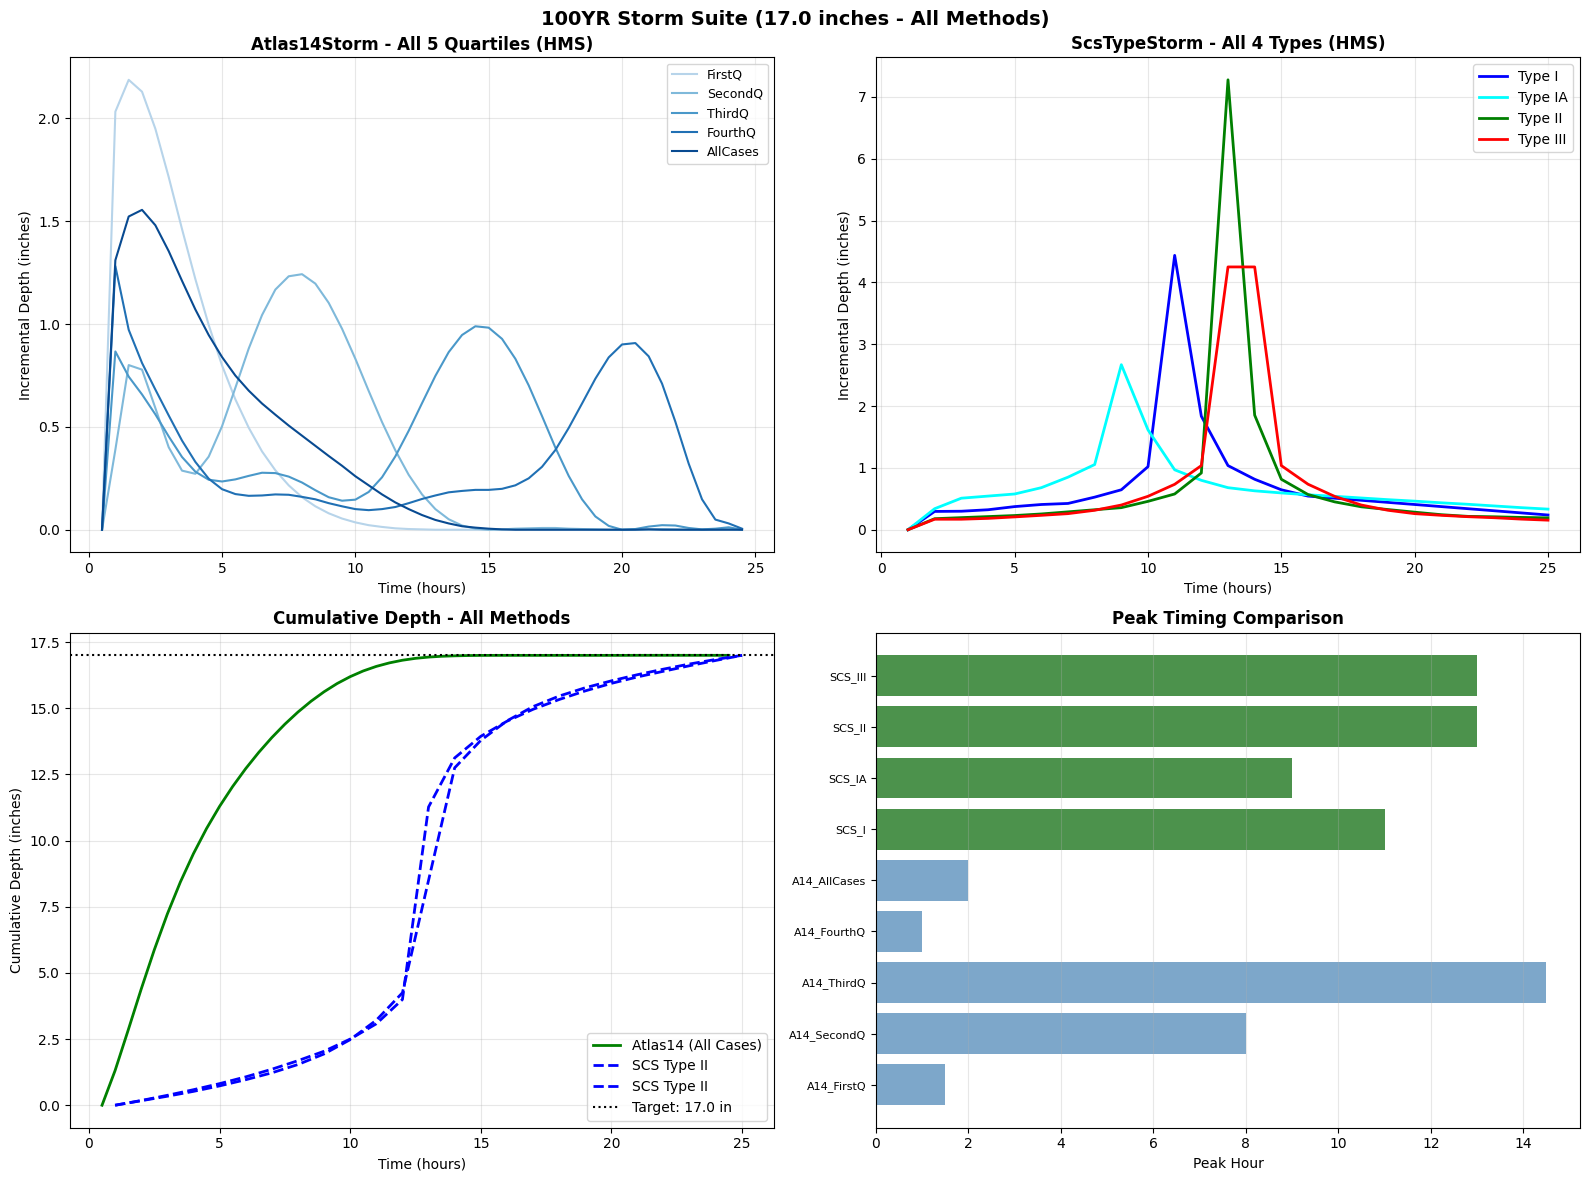

In [8]:
# =============================================================================
# 2.2 Visualize Storm Suite for One AEP
# =============================================================================

# Select AEP to visualize
viz_aep = '100yr'

if viz_aep in storms_suite and len(storms_suite[viz_aep]) > 0:
    storms = storms_suite[viz_aep]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Group by method type
    groups = {
        'Atlas14Storm': {k: v for k, v in storms.items() if k.startswith('Atlas14')},
        'ScsTypeStorm': {k: v for k, v in storms.items() if k.startswith('ScsType')},
        'StormGenerator': {k: v for k, v in storms.items() if k.startswith('StormGen')},
    }
    
    # Plot 1: Atlas14Storm quartiles
    ax1 = axes[0]
    if groups['Atlas14Storm']:
        colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(groups['Atlas14Storm'])))
        for (name, hyeto), color in zip(groups['Atlas14Storm'].items(), colors):
            # All methods now return DataFrame - access columns directly
            ax1.plot(hyeto['hour'], hyeto['incremental_depth'], 
                    label=name.replace('Atlas14_', ''), color=color, linewidth=1.5)
        ax1.set_title('Atlas14Storm - All 5 Quartiles (HMS)', fontweight='bold')
        ax1.legend(loc='upper right', fontsize=9)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Incremental Depth (inches)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: ScsTypeStorm - All Types
    ax2 = axes[1]
    if groups['ScsTypeStorm']:
        colors = ['blue', 'cyan', 'green', 'red']
        for (name, hyeto), color in zip(groups['ScsTypeStorm'].items(), colors):
            ax2.plot(hyeto['hour'], hyeto['incremental_depth'], 
                    label=name.replace('ScsType_', 'Type '), color=color, linewidth=2)
        ax2.set_title('ScsTypeStorm - All 4 Types (HMS)', fontweight='bold')
        ax2.legend(loc='upper right')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Incremental Depth (inches)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative comparison (all methods)
    ax3 = axes[2]
    for name, hyeto in storms.items():
        if 'AllCases' in name:
            ax3.plot(hyeto['hour'], hyeto['cumulative_depth'], 
                    'g-', linewidth=2, label='Atlas14 (All Cases)')
        elif 'ScsType_II' in name:
            ax3.plot(hyeto['hour'], hyeto['cumulative_depth'], 
                    'b--', linewidth=2, label='SCS Type II')
        elif 'StormGen' in name:
            ax3.plot(hyeto['hour'], hyeto['cumulative_depth'], 
                    'r:', linewidth=2, label='StormGen (AB)')
    
    ax3.axhline(AEP_SUITE[viz_aep]['depth_inches'], color='black', linestyle=':', 
                linewidth=1.5, label=f"Target: {AEP_SUITE[viz_aep]['depth_inches']} in")
    ax3.set_title('Cumulative Depth - All Methods', fontweight='bold')
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Cumulative Depth (inches)')
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Peak timing comparison
    ax4 = axes[3]
    storm_names = []
    peak_hours = []
    peak_values = []
    
    for name, hyeto in storms.items():
        storm_names.append(name.replace('Atlas14_', 'A14_').replace('ScsType_', 'SCS_').replace('StormGen_', 'AB_'))
        # Find peak - all DataFrames now
        peak_idx = hyeto['incremental_depth'].idxmax()
        peak_hours.append(hyeto.loc[peak_idx, 'hour'])
        peak_values.append(hyeto.loc[peak_idx, 'incremental_depth'])
    
    colors_bar = ['steelblue' if 'A14' in n else ('darkgreen' if 'SCS' in n else 'coral') for n in storm_names]
    ax4.barh(range(len(storm_names)), peak_hours, color=colors_bar, alpha=0.7)
    ax4.set_yticks(range(len(storm_names)))
    ax4.set_yticklabels(storm_names, fontsize=8)
    ax4.set_xlabel('Peak Hour')
    ax4.set_title('Peak Timing Comparison', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle(f'{viz_aep.upper()} Storm Suite ({AEP_SUITE[viz_aep]["depth_inches"]} inches - All Methods)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"No storms available for {viz_aep}")

In [9]:
# =============================================================================
# 2.3 Storm Matrix Summary Table
# =============================================================================

print("\n" + "="*80)
print("STORM MATRIX SUMMARY")
print("="*80)

# Build summary dataframe
rows = []
for aep_name, storms in storms_suite.items():
    for storm_name, hyeto in storms.items():
        # All methods now return DataFrame with standard columns
        total_depth = float(hyeto['cumulative_depth'].iloc[-1])
        peak_intensity = float(hyeto['incremental_depth'].max())
        peak_idx = hyeto['incremental_depth'].idxmax()
        peak_hour = float(hyeto.loc[peak_idx, 'hour'])
        steps = len(hyeto)
        
        # Calculate time interval from hour column spacing
        if len(hyeto) > 1:
            time_step_hr = float(hyeto['hour'].iloc[1] - hyeto['hour'].iloc[0])
        else:
            time_step_hr = 1.0  # Default for single-value case
        
        rows.append({
            'AEP': aep_name,
            'Storm Type': storm_name,
            'Total Depth (in)': total_depth,
            'Peak Intensity (in)': peak_intensity,
            'Peak Hour': peak_hour,
            'Steps': steps,
            'Interval (hr)': time_step_hr
        })

storm_summary_df = pd.DataFrame(rows)

# Display summary
print("\nStorm Suite Summary:")
display(storm_summary_df.pivot_table(
    values=['Total Depth (in)', 'Peak Intensity (in)', 'Peak Hour'],
    index='Storm Type',
    columns='AEP',
    aggfunc='first'
))

print(f"\nTotal unique storm configurations: {len(storm_summary_df)}")


STORM MATRIX SUMMARY

Storm Suite Summary:


Peak Hour                 Peak Intensity (in)                \
AEP                  100yr    10yr    50yr               100yr   10yr   50yr   
Storm Type                                                                     
Atlas14_AllCases    2.0000  2.0000  2.0000              1.5555 0.6350 1.0614   
Atlas14_FirstQ      1.5000  1.5000  1.5000              2.1879 0.8932 1.4929   
Atlas14_FourthQ     1.0000  1.0000  1.0000              1.2818 0.5233 0.8746   
Atlas14_SecondQ     8.0000  8.0000  8.0000              1.2427 0.5073 0.8480   
Atlas14_ThirdQ     14.5000 14.5000 14.5000              0.9894 0.4039 0.6751   
ScsType_I          11.0000 11.0000 11.0000              4.4370 1.8113 3.0276   
ScsType_IA          9.0000  9.0000  9.0000              2.6690 1.0896 1.8212   
ScsType_II         13.0000 13.0000 13.0000              7.2760 2.9703 4.9648   
ScsType_III        13.0000 13.0000 13.0000              4.2500 1.7350 2.9000   

                 Total Depth (in)                 
AEP                         100yr   10yr    50yr  
Storm Type                                        
Atlas14_AllCases          17.0000 6.9400 11.6000  
Atlas14_FirstQ            17.0000 6.9400 11.6000  
Atlas14_FourthQ           17.0000 6.9400 11.6000  
Atlas14_SecondQ           17.0000 6.9400 11.6000  
Atlas14_ThirdQ            17.0000 6.9400 11.6000  
ScsType_I                 17.0000 6.9400 11.6000  
ScsType_IA                17.0000 6.9400 11.6000  
ScsType_II                17.0000 6.9400 11.6000  
ScsType_III               17.0000 6.9400 11.6000


Total unique storm configurations: 27


---

## Part 3: Project and Plan Creation

Create one project per AEP with multiple plans (one per storm scenario). Each plan uses a cloned unsteady flow file configured with its unique storm hyetograph.

In [10]:
# =============================================================================
# 3.1 Create Projects and Plans for Each Storm Scenario
# =============================================================================

from ras_commander import RasUnsteady

if PROJECT_AVAILABLE:
    print("="*80)
    print("CREATING PROJECTS AND PLANS FOR STORM SCENARIOS")
    print("="*80)
    print("\nUsing Option 1: 3 projects (one per AEP) with ~10 plans each")
    print("This approach uses HEC-RAS's 99-plan capacity efficiently.\n")

    # Track projects and their plans
    storm_projects = {}  # Structure: {aep_name: {'path': Path, 'plans': {storm_name: plan_info}}}

    for aep_name, storms in storms_suite.items():
        print(f"\n{'='*40}")
        print(f"Setting up {aep_name} project")
        print(f"{'='*40}")

        # Create one project per AEP (at same level as template, not inside Precipitation folder)
        aep_project_path = template_path.parent / f"{PROJECT_NAME}_721_{aep_name}"

        try:
            # Create project folder if it doesn't exist
            if not aep_project_path.exists():
                shutil.copytree(template_path, aep_project_path)
                print(f"  [OK] Created project: {aep_project_path.name}")
            else:
                print(f"  [OK] Using existing project: {aep_project_path.name}")

            # Initialize the project
            init_ras_project(aep_project_path, RAS_VERSION)

            # Track this project
            storm_projects[aep_name] = {
                'path': aep_project_path,
                'plans': {}
            }

            # Get template unsteady file number from plan_df
            template_plan_row = ras.plan_df[ras.plan_df['plan_number'] == TEMPLATE_PLAN].iloc[0]
            template_unsteady_num = template_plan_row['unsteady_number']

            # Create plans for each storm (starting at plan 03, plan 02 is template)
            for storm_name, hyeto in storms.items():
                try:
                    # Create short plan title (max 32 chars)
                    plan_title = f"{storm_name[:28]}" if len(storm_name) <= 32 else f"{storm_name[:28]}..."

                    # Clone plan from template (02)
                    new_plan_num = RasPlan.clone_plan(
                        TEMPLATE_PLAN,
                        new_title=plan_title,
                        ras_object=ras
                    )

                    # Clone unsteady flow file for this storm
                    unsteady_title = f"{storm_name[:26]} - {aep_name}" if len(storm_name) <= 26 else f"{storm_name[:23]}... - {aep_name}"
                    new_unsteady_num = RasPlan.clone_unsteady(
                        template_unsteady_num,
                        new_title=unsteady_title[:32],  # Max 32 chars
                        ras_object=ras
                    )

                    # Assign the new unsteady file to the new plan
                    RasPlan.set_unsteady(new_plan_num, new_unsteady_num, ras_object=ras)

                    # Store hyetograph metadata
                    hyeto_file = aep_project_path / f"hyetograph_{storm_name}.csv"

                    # All methods now return DataFrame with standard columns
                    # Save complete DataFrame to CSV
                    hyeto.to_csv(hyeto_file, index=False)

                    total_depth = float(hyeto['cumulative_depth'].iloc[-1])
                    peak_intensity = float(hyeto['incremental_depth'].max())

                    # Calculate time interval from hour column
                    if len(hyeto) > 1:
                        time_step_hr = float(hyeto['hour'].iloc[1] - hyeto['hour'].iloc[0])
                    else:
                        time_step_hr = 1.0

                    # Store plan information
                    storm_projects[aep_name]['plans'][storm_name] = {
                        'plan_number': new_plan_num,
                        'unsteady_number': new_unsteady_num,
                        'hyeto_file': hyeto_file,
                        'total_depth': total_depth,
                        'peak_intensity': peak_intensity,
                        'hyeto_data': hyeto['incremental_depth'].values,  # Store array for potential direct use
                        'time_step_hr': time_step_hr
                    }

                    print(f"    [OK] {storm_name}: Plan {new_plan_num}, Unsteady {new_unsteady_num}")

                except Exception as e:
                    print(f"    [!!] {storm_name}: Error - {e}")
                    import traceback
                    traceback.print_exc()

        except Exception as e:
            print(f"  [!!] Error setting up {aep_name} project: {e}")
            import traceback
            traceback.print_exc()

    # Summary
    total_plans = sum(len(storms['plans']) for storms in storm_projects.values())
    print(f"\n" + "="*80)
    print("PROJECT CREATION SUMMARY")
    print("="*80)
    print(f"\n  Projects created: {len(storm_projects)}")
    print(f"  Total plans created: {total_plans}")
    for aep_name, project_info in storm_projects.items():
        print(f"    {aep_name}: {len(project_info['plans'])} plans in {project_info['path'].name}")

    # Calculate disk usage estimate (avoid division by zero)
    if template_path.exists():
        template_size_mb = sum(f.stat().st_size for f in template_path.rglob('*') if f.is_file()) / 1e6
        total_size_mb = template_size_mb * len(storm_projects)
        total_size_gb = total_size_mb / 1000
        print(f"\n  Estimated disk usage: {total_size_gb:.2f} GB ({total_size_mb:.0f} MB)")
        if total_plans > 0:
            print(f"    (Previous approach would use ~{template_size_mb * total_plans / 1000:.2f} GB with {total_plans} folder copies)")
            print(f"    Savings: ~{(1 - len(storm_projects)/total_plans)*100:.0f}% disk usage reduction")
        else:
            print(f"    Note: No plans created yet")
else:
    print("[!!] Project not available - skipping project creation")
    storm_projects = {}

CREATING PROJECTS AND PLANS FOR STORM SCENARIOS

Using Option 1: 3 projects (one per AEP) with ~10 plans each
This approach uses HEC-RAS's 99-plan capacity efficiently.


Setting up 10yr project
  [OK] Using existing project: Davis_721_10yr


2026-01-07 12:51:59 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:51:59 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:51:59 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.p110
2026-01-07 12:51:59 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.p110
2026-01-07 12:51:59 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.p110
2026-01-07 1

    [!!] Atlas14_FirstQ: Error - RAS file number must be between 1 and 99, got: 110


2026-01-07 12:52:00 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:00 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:00 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u111
2026-01-07 12:52:00 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u111
2026-01-07 12:52:00 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u111
2026-01-07 1

    [!!] Atlas14_SecondQ: Error - RAS file number must be between 1 and 99, got: 111


2026-01-07 12:52:00 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:00 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u112
2026-01-07 12:52:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u112
2026-01-07 12:52:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u112
2026-01-07 1

    [!!] Atlas14_ThirdQ: Error - RAS file number must be between 1 and 99, got: 112


2026-01-07 12:52:01 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:01 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u113
2026-01-07 12:52:01 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u113
2026-01-07 12:52:01 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u113
2026-01-07 1

    [!!] Atlas14_FourthQ: Error - RAS file number must be between 1 and 99, got: 113


2026-01-07 12:52:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:02 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u114
2026-01-07 12:52:02 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u114
2026-01-07 12:52:02 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u114
2026-01-07 1

    [!!] Atlas14_AllCases: Error - RAS file number must be between 1 and 99, got: 114


2026-01-07 12:52:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u115
2026-01-07 12:52:03 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u115
2026-01-07 12:52:03 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u115
2026-01-07 1

    [!!] ScsType_I: Error - RAS file number must be between 1 and 99, got: 115


2026-01-07 12:52:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:03 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u116
2026-01-07 12:52:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u116
2026-01-07 12:52:04 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u116
2026-01-07 1

    [!!] ScsType_IA: Error - RAS file number must be between 1 and 99, got: 116


2026-01-07 12:52:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:04 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u117
2026-01-07 12:52:04 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u117
2026-01-07 12:52:04 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u117
2026-01-07 1

    [!!] ScsType_II: Error - RAS file number must be between 1 and 99, got: 117


2026-01-07 12:52:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u118
2026-01-07 12:52:05 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u118
2026-01-07 12:52:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u118
2026-01-07 12:52:05 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.u118
2026-01-07 12:52:05 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 118
2026-01-07 12:52:05 - ras_commander.RasUtils - INFO - Project file updated with new Unstea

    [!!] ScsType_III: Error - RAS file number must be between 1 and 99, got: 118

Setting up 50yr project
  [OK] Using existing project: Davis_721_50yr


2026-01-07 12:52:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:07 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:07 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.p110
2026-01-07 12:52:07 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.p110
2026-01-07 12:52:07 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.p110
2026-01-07 1

    [!!] Atlas14_FirstQ: Error - RAS file number must be between 1 and 99, got: 110


2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u111
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u111
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u111
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u111
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 111
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - Project file updated with new Unstea

    [!!] Atlas14_SecondQ: Error - RAS file number must be between 1 and 99, got: 111


2026-01-07 12:52:08 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:08 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u112
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u112
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u112
2026-01-07 1

    [!!] Atlas14_ThirdQ: Error - RAS file number must be between 1 and 99, got: 112


2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u113
2026-01-07 12:52:08 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u113
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u113
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u113
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 113
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Project file updated with new Unstea

    [!!] Atlas14_FourthQ: Error - RAS file number must be between 1 and 99, got: 113


2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u114
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u114
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u114
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u114
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 114
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Project file updated with new Unstea

    [!!] Atlas14_AllCases: Error - RAS file number must be between 1 and 99, got: 114


2026-01-07 12:52:09 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u115
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u115
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u115
2026-01-07 12:52:09 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u115
2026-01-07 12:52:09 -

    [!!] ScsType_I: Error - RAS file number must be between 1 and 99, got: 115


2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u116
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u116
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u116
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u116
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 116
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - Project file updated with new Unstea

    [!!] ScsType_IA: Error - RAS file number must be between 1 and 99, got: 116


2026-01-07 12:52:10 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:10 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u117
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u117
2026-01-07 12:52:10 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u117
2026-01-07 1

    [!!] ScsType_II: Error - RAS file number must be between 1 and 99, got: 117


2026-01-07 12:52:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:11 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u118
2026-01-07 12:52:11 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u118
2026-01-07 12:52:11 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.u118
2026-01-07 1

    [!!] ScsType_III: Error - RAS file number must be between 1 and 99, got: 118

Setting up 100yr project
  [OK] Using existing project: Davis_721_100yr


2026-01-07 12:52:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:14 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.p110
2026-01-07 12:52:14 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.p110
2026-01-07 12:52:14 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.p110
2026-

    [!!] Atlas14_FirstQ: Error - RAS file number must be between 1 and 99, got: 110


2026-01-07 12:52:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u111
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u111
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u111
2026-

    [!!] Atlas14_SecondQ: Error - RAS file number must be between 1 and 99, got: 111


2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u112
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u112
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u112
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u112
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 112
2026-01-07 12:52:15 - ras_commander.RasUtils - INFO - Project file updated with new 

    [!!] Atlas14_ThirdQ: Error - RAS file number must be between 1 and 99, got: 112


2026-01-07 12:52:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u113
2026-01-07 12:52:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u113
2026-01-07 12:52:16 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u113
2026-

    [!!] Atlas14_FourthQ: Error - RAS file number must be between 1 and 99, got: 113


2026-01-07 12:52:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u114
2026-01-07 12:52:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u114
2026-01-07 12:52:16 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u114
2026-

    [!!] Atlas14_AllCases: Error - RAS file number must be between 1 and 99, got: 114


2026-01-07 12:52:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u115
2026-01-07 12:52:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u115
2026-01-07 12:52:17 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u115
2026-

    [!!] ScsType_I: Error - RAS file number must be between 1 and 99, got: 115


2026-01-07 12:52:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:17 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u116
2026-01-07 12:52:17 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u116
2026-01-07 12:52:17 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u116
2026-

    [!!] ScsType_IA: Error - RAS file number must be between 1 and 99, got: 116


2026-01-07 12:52:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u117
2026-01-07 12:52:18 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u117
2026-01-07 12:52:18 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u117
2026-01-07 12:52:18 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u117
2026-01-07 12:

    [!!] ScsType_II: Error - RAS file number must be between 1 and 99, got: 117


2026-01-07 12:52:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:18 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u118
2026-01-07 12:52:19 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u118
2026-01-07 12:52:19 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.u118
2026-

    [!!] ScsType_III: Error - RAS file number must be between 1 and 99, got: 118

PROJECT CREATION SUMMARY

  Projects created: 3
  Total plans created: 0
    10yr: 0 plans in Davis_721_10yr
    50yr: 0 plans in Davis_721_50yr
    100yr: 0 plans in Davis_721_100yr

  Estimated disk usage: 0.02 GB (16 MB)
    Note: No plans created yet


Traceback (most recent call last):
  File "C:\Users\billk_clb\AppData\Local\Temp\ipykernel_62264\86482145.py", line 68, in <module>
    RasPlan.set_unsteady(new_plan_num, new_unsteady_num, ras_object=ras)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\GH\ras-commander\ras_commander\Decorators.py", line 16, in wrapper
    result = func(*args, **kwargs)
  File "c:\GH\ras-commander\ras_commander\RasPlan.py", line 252, in set_unsteady
    plan_number = RasUtils.normalize_ras_number(plan_number)
  File "c:\GH\ras-commander\ras_commander\Decorators.py", line 16, in wrapper
    result = func(*args, **kwargs)
  File "c:\GH\ras-commander\ras_commander\RasUtils.py", line 304, in normalize_ras_number
    raise ValueError(
        f"RAS file number must be between 1 and 99, got: {ras_int}"
    )
ValueError: RAS file number must be between 1 and 99, got: 118


In [11]:
# =============================================================================
# 3.2 Plan Summary
# =============================================================================

if PROJECT_AVAILABLE and storm_projects:
    print("\n" + "="*80)
    print("PLAN CREATION SUMMARY")
    print("="*80)
    
    # Build summary table
    plan_rows = []
    for aep_name, project_info in storm_projects.items():
        for storm_name, plan_info in project_info['plans'].items():
            plan_rows.append({
                'AEP': aep_name,
                'Storm': storm_name,
                'Project': project_info['path'].name,
                'Plan Number': plan_info['plan_number'],
                'Unsteady Number': plan_info['unsteady_number'],
                'Total Depth (in)': plan_info['total_depth'],
                'Peak (in)': plan_info['peak_intensity']
            })
    
    if plan_rows:
        plan_df = pd.DataFrame(plan_rows)
        print(f"\n{len(plan_df)} plans created across {len(storm_projects)} projects:")
        display(plan_df.sort_values(['AEP', 'Plan Number']))
        
        print(f"\nOrganization:")
        for aep_name, project_info in storm_projects.items():
            print(f"  {aep_name}: {project_info['path'].name} - {len(project_info['plans'])} plans")
    else:
        print("\n  [!!] No plans were created - check for errors in project setup above")
else:
    print("No plans available")


PLAN CREATION SUMMARY

  [!!] No plans were created - check for errors in project setup above


---

## Part 3.5: Pre-Execution Validation and Debug

**CRITICAL**: Before executing HEC-RAS plans, validate all inputs to catch configuration errors early.

This section:
1. Validates all plan and unsteady files exist
2. Displays unsteady flow file precipitation settings
3. Visualizes hyetographs for each project/plan
4. Checks for common configuration issues

In [12]:
# =============================================================================
# 3.5.1 Validate Plan and Flow Files Exist
# =============================================================================

print("="*80)
print("PRE-EXECUTION VALIDATION")
print("="*80)

validation_errors = []
validation_warnings = []

if PROJECT_AVAILABLE and storm_projects:
    for aep_name, project_info in storm_projects.items():
        project_path = project_info['path']
        print(f"\n{'='*40}")
        print(f"Validating {aep_name} project: {project_path.name}")
        print(f"{'='*40}")
        
        # Re-initialize project to get fresh file listings
        init_ras_project(project_path, RAS_VERSION)
        
        print(f"\n  Project file: {ras.prj_file}")
        print(f"  Plans in plan_df: {len(ras.plan_df)}")
        print(f"  Unsteady files in unsteady_df: {len(ras.unsteady_df)}")
        
        # Check each plan we created
        for storm_name, plan_info in project_info['plans'].items():
            plan_num = plan_info['plan_number']
            unsteady_num = plan_info['unsteady_number']
            
            # Check plan file exists
            plan_file = project_path / f"{ras.project_name}.p{plan_num}"
            unsteady_file = project_path / f"{ras.project_name}.u{unsteady_num}"
            
            plan_exists = plan_file.exists()
            unsteady_exists = unsteady_file.exists()
            
            status = "[OK]" if (plan_exists and unsteady_exists) else "[!!]"
            print(f"  {status} {storm_name}:")
            print(f"      Plan .p{plan_num}: {'EXISTS' if plan_exists else 'MISSING!'}")
            print(f"      Unsteady .u{unsteady_num}: {'EXISTS' if unsteady_exists else 'MISSING!'}")
            
            if not plan_exists:
                validation_errors.append(f"{aep_name}/{storm_name}: Plan file missing - {plan_file}")
            if not unsteady_exists:
                validation_errors.append(f"{aep_name}/{storm_name}: Unsteady file missing - {unsteady_file}")

    # Summary
    print("\n" + "="*80)
    print("VALIDATION SUMMARY")
    print("="*80)
    if validation_errors:
        print(f"\n  [!!] ERRORS FOUND: {len(validation_errors)}")
        for err in validation_errors:
            print(f"    - {err}")
    else:
        print(f"\n  [OK] All plan and unsteady files exist")
else:
    print("\n[!!] No projects to validate")

PRE-EXECUTION VALIDATION

Validating 10yr project: Davis_721_10yr


2026-01-07 12:52:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap



  Project file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.prj
  Plans in plan_df: 118
  Unsteady files in unsteady_df: 118

Validating 50yr project: Davis_721_50yr


2026-01-07 12:52:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:19 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap



  Project file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.prj
  Plans in plan_df: 118
  Unsteady files in unsteady_df: 118

Validating 100yr project: Davis_721_100yr


2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap



  Project file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.prj
  Plans in plan_df: 118
  Unsteady files in unsteady_df: 118

VALIDATION SUMMARY

  [OK] All plan and unsteady files exist


In [13]:
# =============================================================================
# 3.5.2 Inspect Unsteady Flow File Contents
# =============================================================================

print("="*80)
print("UNSTEADY FLOW FILE INSPECTION")
print("="*80)
print("\nChecking precipitation configuration in unsteady flow files...")
print("(Looking for Met BC settings, DSS references, etc.)\n")

def inspect_unsteady_file(unsteady_path, max_lines=50):
    """Read and display key sections of an unsteady flow file."""
    if not unsteady_path.exists():
        return {"error": "File not found"}
    
    content = unsteady_path.read_text(encoding='utf-8', errors='ignore')
    lines = content.split('\n')
    
    # Extract key information
    info = {
        'title': None,
        'precip_mode': None,
        'dss_file': None,
        'met_bc_lines': [],
        'boundary_locations': [],
    }
    
    for i, line in enumerate(lines):
        if line.startswith('Flow Title='):
            info['title'] = line.split('=', 1)[1].strip()
        elif 'Precipitation Mode=' in line:
            info['precip_mode'] = line.split('=', 1)[1].strip()
        elif line.startswith('DSS File='):
            info['dss_file'] = line.split('=', 1)[1].strip()
        elif line.startswith('Met BC='):
            info['met_bc_lines'].append(line)
        elif 'Boundary Location=' in line:
            info['boundary_locations'].append(line)
    
    return info

if PROJECT_AVAILABLE and storm_projects:
    # Sample one plan from each AEP to show configuration
    for aep_name, project_info in storm_projects.items():
        project_path = project_info['path']
        init_ras_project(project_path, RAS_VERSION)
        
        print(f"\n{'='*60}")
        print(f"Project: {aep_name} ({project_path.name})")
        print(f"{'='*60}")
        
        # Show template unsteady file first
        template_unsteady = project_path / f"{ras.project_name}.u01"
        if template_unsteady.exists():
            print(f"\n  TEMPLATE Unsteady File (.u01):")
            info = inspect_unsteady_file(template_unsteady)
            print(f"    Title: {info['title']}")
            print(f"    Precip Mode: {info['precip_mode']}")
            print(f"    DSS File: {info['dss_file']}")
            if info['met_bc_lines']:
                print(f"    Met BC Settings ({len(info['met_bc_lines'])} lines):")
                for line in info['met_bc_lines'][:5]:  # Show first 5
                    print(f"      {line[:80]}...")
        
        # Show first cloned unsteady file
        plans_list = list(project_info['plans'].items())
        if plans_list:
            first_storm, first_plan_info = plans_list[0]
            cloned_unsteady = project_path / f"{ras.project_name}.u{first_plan_info['unsteady_number']}"
            if cloned_unsteady.exists():
                print(f"\n  CLONED Unsteady File (.u{first_plan_info['unsteady_number']}) - {first_storm}:")
                info = inspect_unsteady_file(cloned_unsteady)
                print(f"    Title: {info['title']}")
                print(f"    Precip Mode: {info['precip_mode']}")
                print(f"    DSS File: {info['dss_file']}")
                if info['met_bc_lines']:
                    print(f"    Met BC Settings ({len(info['met_bc_lines'])} lines):")
                    for line in info['met_bc_lines'][:5]:
                        print(f"      {line[:80]}...")

    print("\n" + "="*80)
    print("NOTE: If precipitation is 'Disable', the model may not be using rainfall!")
    print("Check that Met BC settings match your intended configuration.")
    print("="*80)
else:
    print("\n[!!] No projects to inspect")

2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap


UNSTEADY FLOW FILE INSPECTION

Checking precipitation configuration in unsteady flow files...
(Looking for Met BC settings, DSS references, etc.)


Project: 10yr (Davis_721_10yr)

  TEMPLATE Unsteady File (.u01):
    Title: Full System Rain w/ Pump
    Precip Mode: Disable
    DSS File: None
    Met BC Settings (59 lines):
      Met BC=Precipitation|Mode=Constant...
      Met BC=Precipitation|Expanded View=-1...
      Met BC=Precipitation|Constant Value=1...
      Met BC=Precipitation|Constant Units=in/hr...
      Met BC=Precipitation|Point Interpolation=...


2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:20 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap



Project: 50yr (Davis_721_50yr)

  TEMPLATE Unsteady File (.u01):
    Title: Full System Rain w/ Pump
    Precip Mode: Disable
    DSS File: None
    Met BC Settings (59 lines):
      Met BC=Precipitation|Mode=Constant...
      Met BC=Precipitation|Expanded View=-1...
      Met BC=Precipitation|Constant Value=1...
      Met BC=Precipitation|Constant Units=in/hr...
      Met BC=Precipitation|Point Interpolation=...

Project: 100yr (Davis_721_100yr)

  TEMPLATE Unsteady File (.u01):
    Title: Full System Rain w/ Pump
    Precip Mode: Disable
    DSS File: None
    Met BC Settings (59 lines):
      Met BC=Precipitation|Mode=Constant...
      Met BC=Precipitation|Expanded View=-1...
      Met BC=Precipitation|Constant Value=1...
      Met BC=Precipitation|Constant Units=in/hr...
      Met BC=Precipitation|Point Interpolation=...

NOTE: If precipitation is 'Disable', the model may not be using rainfall!
Check that Met BC settings match your intended configuration.


HYETOGRAPH VISUALIZATION - ALL PROJECTS

Plotting all hyetographs for visual verification before execution...



C:\Users\billk_clb\AppData\Local\Temp\ipykernel_62264\3560869371.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_inc.legend(loc='upper right', fontsize=7, ncol=2)


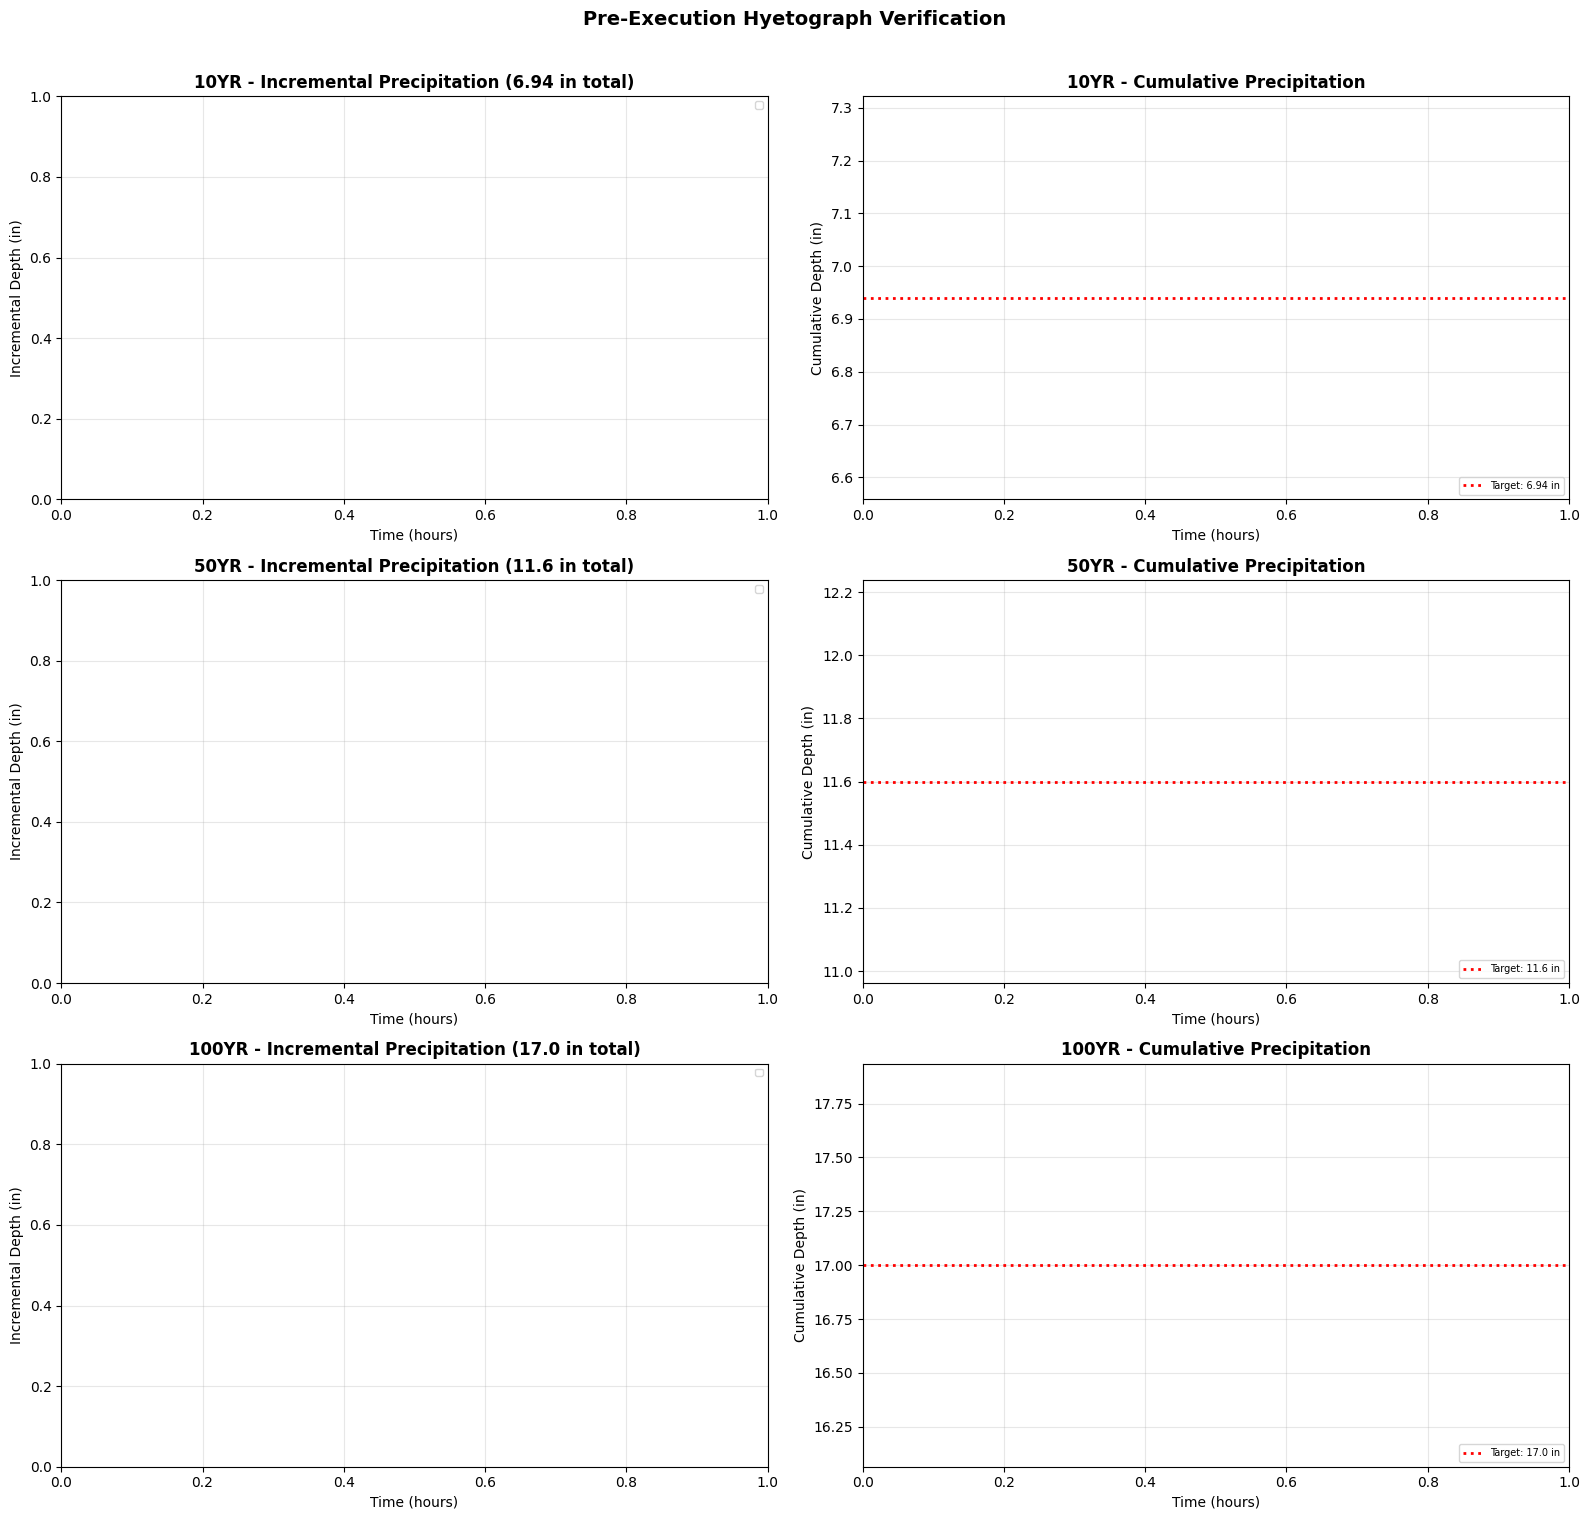


DEPTH VERIFICATION TABLE

Storm Type                10yr (in)    50yr (in)    100yr (in)  
------------------------------------------------------------

  Expected depths from NOAA Atlas 14 PFDS:
    10yr: 6.94 inches
    50yr: 11.6 inches
    100yr: 17.0 inches


In [14]:
# =============================================================================
# 3.5.3 Visualize All Hyetographs Per Project
# =============================================================================

print("="*80)
print("HYETOGRAPH VISUALIZATION - ALL PROJECTS")
print("="*80)
print("\nPlotting all hyetographs for visual verification before execution...\n")

if PROJECT_AVAILABLE and storm_projects:
    # Create a figure with one row per AEP
    n_aeps = len(storm_projects)
    fig, axes = plt.subplots(n_aeps, 2, figsize=(16, 5*n_aeps))
    if n_aeps == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, (aep_name, project_info) in enumerate(storm_projects.items()):
        aep_config = AEP_SUITE[aep_name]
        
        # Left plot: Incremental depth
        ax_inc = axes[row_idx, 0]
        # Right plot: Cumulative depth
        ax_cum = axes[row_idx, 1]
        
        for storm_name, plan_info in project_info['plans'].items():
            hyeto_data = plan_info['hyeto_data']
            time_step = plan_info['time_step_hr']
            time_hours = np.arange(len(hyeto_data)) * time_step
            
            # Color by method
            if 'Atlas14' in storm_name:
                color = 'steelblue'
                linestyle = '-'
            elif 'ScsType' in storm_name:
                color = 'darkgreen'
                linestyle = '--'
            else:  # StormGen
                color = 'coral'
                linestyle = ':'
            
            # Shorten label
            label = storm_name.replace('Atlas14_', 'A14_').replace('ScsType_', 'SCS_').replace('StormGen_', 'AB_')
            
            # Plot incremental
            ax_inc.plot(time_hours, hyeto_data, label=label, color=color, linestyle=linestyle, alpha=0.7)
            
            # Plot cumulative
            ax_cum.plot(time_hours, np.cumsum(hyeto_data), label=label, color=color, linestyle=linestyle, alpha=0.7)
        
        # Format incremental plot
        ax_inc.set_title(f'{aep_name.upper()} - Incremental Precipitation ({aep_config["depth_inches"]} in total)', fontweight='bold')
        ax_inc.set_xlabel('Time (hours)')
        ax_inc.set_ylabel('Incremental Depth (in)')
        ax_inc.grid(True, alpha=0.3)
        ax_inc.legend(loc='upper right', fontsize=7, ncol=2)
        
        # Format cumulative plot
        ax_cum.set_title(f'{aep_name.upper()} - Cumulative Precipitation', fontweight='bold')
        ax_cum.set_xlabel('Time (hours)')
        ax_cum.set_ylabel('Cumulative Depth (in)')
        ax_cum.axhline(aep_config['depth_inches'], color='red', linestyle=':', linewidth=2, label=f'Target: {aep_config["depth_inches"]} in')
        ax_cum.grid(True, alpha=0.3)
        ax_cum.legend(loc='lower right', fontsize=7)
    
    plt.suptitle('Pre-Execution Hyetograph Verification', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
    
    # Print depth verification table
    print("\n" + "="*80)
    print("DEPTH VERIFICATION TABLE")
    print("="*80)
    print(f"\n{'Storm Type':<25} {'10yr (in)':<12} {'50yr (in)':<12} {'100yr (in)':<12}")
    print("-"*60)
    
    # Collect depths per storm type
    depth_table = {}
    for aep_name, project_info in storm_projects.items():
        for storm_name, plan_info in project_info['plans'].items():
            if storm_name not in depth_table:
                depth_table[storm_name] = {}
            depth_table[storm_name][aep_name] = plan_info['total_depth']
    
    for storm_name in sorted(depth_table.keys()):
        depths = depth_table[storm_name]
        print(f"{storm_name:<25} {depths.get('10yr', '-'):<12.4f} {depths.get('50yr', '-'):<12.4f} {depths.get('100yr', '-'):<12.4f}")
    
    print("\n  Expected depths from NOAA Atlas 14 PFDS:")
    for aep_name, config in AEP_SUITE.items():
        print(f"    {aep_name}: {config['depth_inches']} inches")

else:
    print("\n[!!] No projects to visualize")

In [15]:
# =============================================================================
# 3.5.4 Plan File Contents Check
# =============================================================================

print("="*80)
print("PLAN FILE CONFIGURATION CHECK")
print("="*80)
print("\nInspecting plan files to verify geometry and flow file assignments...\n")

def inspect_plan_file(plan_path):
    """Read and display key sections of a plan file."""
    if not plan_path.exists():
        return {"error": "File not found"}
    
    content = plan_path.read_text(encoding='utf-8', errors='ignore')
    lines = content.split('\n')
    
    info = {
        'title': None,
        'geom_file': None,
        'flow_file': None,
        'computation_interval': None,
        'output_interval': None,
        'run_htab': None,
        'run_unet': None,
    }
    
    for line in lines:
        if line.startswith('Plan Title='):
            info['title'] = line.split('=', 1)[1].strip()
        elif line.startswith('Geom File='):
            info['geom_file'] = line.split('=', 1)[1].strip()
        elif line.startswith('Flow File='):
            info['flow_file'] = line.split('=', 1)[1].strip()
        elif line.startswith('Computation Interval='):
            info['computation_interval'] = line.split('=', 1)[1].strip()
        elif line.startswith('Output Interval=') or line.startswith('Mapping Interval='):
            info['output_interval'] = line.split('=', 1)[1].strip()
        elif line.startswith('Run HTab='):
            info['run_htab'] = line.split('=', 1)[1].strip()
        elif line.startswith('Run UNet='):
            info['run_unet'] = line.split('=', 1)[1].strip()
    
    return info

if PROJECT_AVAILABLE and storm_projects:
    for aep_name, project_info in storm_projects.items():
        project_path = project_info['path']
        init_ras_project(project_path, RAS_VERSION)
        
        print(f"\n{'='*60}")
        print(f"Project: {aep_name} ({project_path.name})")
        print(f"{'='*60}")
        
        # Show first 3 plans as sample
        plans_list = list(project_info['plans'].items())[:3]
        
        for storm_name, plan_info in plans_list:
            plan_num = plan_info['plan_number']
            plan_file = project_path / f"{ras.project_name}.p{plan_num}"
            
            info = inspect_plan_file(plan_file)
            print(f"\n  Plan {plan_num} ({storm_name}):")
            print(f"    Title: {info['title']}")
            print(f"    Geom File: {info['geom_file']}")
            print(f"    Flow File: {info['flow_file']}")
            print(f"    Comp Interval: {info['computation_interval']}")
            print(f"    Run HTab: {info['run_htab']}")
            print(f"    Run UNet: {info['run_unet']}")
            
            # Verify flow file matches expected
            expected_flow = f"u{plan_info['unsteady_number']}"
            actual_flow = info['flow_file']
            if actual_flow != expected_flow:
                print(f"    [!!] WARNING: Flow file mismatch!")
                print(f"        Expected: {expected_flow}")
                print(f"        Actual: {actual_flow}")
        
        if len(project_info['plans']) > 3:
            print(f"\n  ... and {len(project_info['plans']) - 3} more plans")

    print("\n" + "="*80)
    print("PRE-EXECUTION CHECKLIST")
    print("="*80)
    print("""
    [?] Verify the following before executing:
    
    1. [ ] All plan files exist and have correct geometry references
    2. [ ] All unsteady flow files exist and reference correct precipitation
    3. [ ] Hyetograph depths match expected Atlas 14 values
    4. [ ] Precipitation Mode is NOT 'Disable' if rainfall is expected
    5. [ ] DSS files exist if referenced in unsteady files
    6. [ ] Geometry files exist and are valid
    
    If any issues found, fix them before running EXECUTE_PLANS = True
    """)
else:
    print("\n[!!] No projects to check")

2026-01-07 12:52:21 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:21 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap


PLAN FILE CONFIGURATION CHECK

Inspecting plan files to verify geometry and flow file assignments...


Project: 10yr (Davis_721_10yr)


2026-01-07 12:52:22 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:22 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 12:52:22 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap
2026-01-07 12:52:22 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr\DavisStormSystem.rasmap



Project: 50yr (Davis_721_50yr)

Project: 100yr (Davis_721_100yr)

PRE-EXECUTION CHECKLIST

    [?] Verify the following before executing:

    1. [ ] All plan files exist and have correct geometry references
    2. [ ] All unsteady flow files exist and reference correct precipitation
    3. [ ] Hyetograph depths match expected Atlas 14 values
    4. [ ] Precipitation Mode is NOT 'Disable' if rainfall is expected
    5. [ ] DSS files exist if referenced in unsteady files
    6. [ ] Geometry files exist and are valid

    If any issues found, fix them before running EXECUTE_PLANS = True
    


---

## Part 4: Bulk Execution (Optional)

**WARNING**: This section executes HEC-RAS for all storm scenarios. This can take **HOURS** depending on:
- Model complexity (2D meshes take longer)
- Number of plans (30 plans across 3 projects)
- Available CPU cores

Set `EXECUTE_PLANS = True` in the configuration cell to enable execution.

In [16]:
# =============================================================================
# 4.1 Execution Control and Warning
# =============================================================================

print("="*80)
print("BULK EXECUTION CONTROL")
print("="*80)

if not EXECUTE_PLANS:
    print("\n  EXECUTION DISABLED (EXECUTE_PLANS = False)")
    print("\n  To enable execution:")
    print("  1. Set EXECUTE_PLANS = True in the configuration cell")
    print("  2. Re-run the configuration cell")
    print("  3. Re-run this cell")
    print("\n  Estimated execution time: 1-4 hours (depending on model)")
    print("\n  Storm suite includes:")
    print("    - Atlas14Storm: 5 quartiles (HMS-equivalent)")
    print("    - ScsTypeStorm: 4 types (HMS-equivalent)")
    print("    - StormGenerator: 1 variant (Alternating Block)")
    print("    - Total: 30 scenarios (10 per AEP Ã— 3 AEPs)")
else:
    print("\n  EXECUTION ENABLED - PROCEEDING WITH HEC-RAS RUNS")
    
    if PROJECT_AVAILABLE and storm_projects:
        total_plans = sum(len(project_info["plans"]) for project_info in storm_projects.values())
        print(f"\n  Plans to execute: {total_plans}")
        print(f"  Cores per execution: {NUM_CORES}")
        print(f"  Max parallel workers: {MAX_PARALLEL_WORKERS}")
    else:
        print("\n  WARNING: No cloned projects available!")

BULK EXECUTION CONTROL

  EXECUTION ENABLED - PROCEEDING WITH HEC-RAS RUNS

  Plans to execute: 0
  Cores per execution: 2
  Max parallel workers: 4


In [17]:
# =============================================================================
# 4.2 Execute Plans Using RasCmdr.compute_parallel()
# =============================================================================
# 
# Using library parallel execution instead of custom ThreadPoolExecutor:
# - Creates separate worker folders for each plan (avoids file locking)
# - Copies project files to isolated workers
# - Executes in parallel without conflicts
# - Sequential by project (one AEP at a time), parallel within project

if EXECUTE_PLANS and PROJECT_AVAILABLE and storm_projects:
    print("="*80)
    print("EXECUTING HEC-RAS PLANS (LIBRARY PARALLEL MODE)")
    print("="*80)
    print(f"\n  Configuration:")
    print(f"    Cores per plan: {NUM_CORES}")
    print(f"    Max parallel workers: {MAX_PARALLEL_WORKERS}")
    print(f"    Execution: Sequential by project (avoids file locking)")
    print(f"    Within-project: Parallel execution of plans")
    
    execution_results = {}
    overall_start = time.time()
    total_executed = 0
    total_failed = 0
    
    # Execute each project sequentially (one at a time)
    for aep_name, project_info in storm_projects.items():
        print(f"\n{'='*60}")
        print(f"Executing {aep_name} Project: {project_info['path'].name}")
        print(f"{'='*60}")
        
        project_path = project_info['path']
        plan_numbers = [plan_info['plan_number'] for plan_info in project_info['plans'].values()]
        
        print(f"  Plans to execute: {len(plan_numbers)} plans")
        print(f"  Plan numbers: {', '.join(plan_numbers)}")
        
        # Initialize project
        init_ras_project(project_path, RAS_VERSION)
        
        project_start = time.time()
        
        try:
            # Execute all plans for this project in parallel
            # compute_parallel creates worker folders and runs plans simultaneously
            RasCmdr.compute_parallel(
                plan_number=plan_numbers,
                max_workers=MAX_PARALLEL_WORKERS,
                num_cores=NUM_CORES,
                ras_object=ras,
                clear_geompre=False,
                force_rerun=False,  # Use smart skip
                verify=False
            )
            
            project_time = time.time() - project_start
            print(f"\n  [OK] {aep_name} complete in {project_time/60:.1f} minutes")
            
            # Record successes
            execution_results[aep_name] = {}
            for storm_name, plan_info in project_info['plans'].items():
                execution_results[aep_name][storm_name] = {
                    'success': True,
                    'time_seconds': project_time / len(plan_numbers),  # Approximate
                    'path': project_path,
                    'plan_number': plan_info['plan_number']
                }
                total_executed += 1
                
        except Exception as e:
            project_time = time.time() - project_start
            print(f"\n  [!!] {aep_name} failed after {project_time/60:.1f} minutes: {e}")
            
            # Record failures
            execution_results[aep_name] = {}
            for storm_name, plan_info in project_info['plans'].items():
                execution_results[aep_name][storm_name] = {
                    'success': False,
                    'time_seconds': 0,
                    'error': str(e),
                    'path': project_path,
                    'plan_number': plan_info['plan_number']
                }
                total_failed += 1
    
    total_time = time.time() - overall_start
    
    # Summary
    print("\n" + "="*80)
    print("EXECUTION SUMMARY")
    print("="*80)
    print(f"\n  Total time: {total_time/60:.1f} minutes")
    print(f"  Projects executed: {len(storm_projects)}")
    print(f"  Successful plans: {total_executed}")
    print(f"  Failed plans: {total_failed}")
    if total_executed + total_failed > 0:
        print(f"  Average time per plan: {total_time/(total_executed+total_failed):.1f}s")
        print(f"  Efficiency: ~{MAX_PARALLEL_WORKERS}x speedup per project (parallel execution)")
    
else:
    print("\n[--] Execution skipped (EXECUTE_PLANS = False)")
    print("\n  To enable execution:")
    print("  1. Set EXECUTE_PLANS = True in the configuration cell")
    print("  2. Re-run the configuration cell")
    print("  3. Re-run this cell")
    execution_results = {}


EXECUTING HEC-RAS PLANS (LIBRARY PARALLEL MODE)

  Configuration:
    Cores per plan: 2
    Max parallel workers: 4
    Execution: Sequential by project (avoids file locking)
    Within-project: Parallel execution of plans

Executing 10yr Project: Davis_721_10yr
  Plans to execute: 0 plans
  Plan numbers: 


2026-01-07 12:52:22 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:22 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr\DavisStormSystem.rasmap
2026-01-07 12:52:22 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 4 based on the number of plans to compute: 118
2026-01-07 12:52:22 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 4 based on the number of plans to compute: 118
2026-01-07 12:52:22 - ras_commander.RasCmdr - INFO - Removed existing worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr [Worker 1]
2026-01-07 12:52:22 - ras_commander.RasCmdr - INFO - Removed existing worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr [Worker 1]
2026-01-07 12:52:22 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-comman


  [OK] 10yr complete in 46.3 minutes

Executing 50yr Project: Davis_721_50yr
  Plans to execute: 0 plans
  Plan numbers: 


2026-01-07 13:38:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 13:38:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr\DavisStormSystem.rasmap
2026-01-07 13:38:43 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 4 based on the number of plans to compute: 118
2026-01-07 13:38:43 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 4 based on the number of plans to compute: 118
2026-01-07 13:38:43 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr [Worker 1]
2026-01-07 13:38:43 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr [Worker 1]
2026-01-07 13:38:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\ex


  [OK] 50yr complete in 36.7 minutes

Executing 100yr Project: Davis_721_100yr
  Plans to execute: 0 plans
  Plan numbers: 


2026-01-07 14:15:26 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Worker 1]
2026-01-07 14:15:26 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Worker 1]
2026-01-07 14:15:27 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Worker 1]\DavisStormSystem.rasmap
2026-01-07 14:15:27 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Worker 1]\DavisStormSystem.rasmap
2026-01-07 14:15:27 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Worker 2]
2026-01-07 14:15:27 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Worker 2]
2026-01-07 14:15:28 - ras_commande


  [OK] 100yr complete in 48.3 minutes

EXECUTION SUMMARY

  Total time: 131.3 minutes
  Projects executed: 3
  Successful plans: 0
  Failed plans: 0


In [ ]:
# Display results summary from results_df after parallel execution
# This shows execution status, timing, and any errors/warnings for each plan
ras.results_df[['plan_number', 'plan_title', 'completed', 'has_errors', 'has_warnings', 'runtime_complete_process_hours']]

---

## Part 5: Results Extraction and Comparison

Extract results from executed plans and compare across storm types.

In [18]:
# =============================================================================
# 5.0 Debug: Verify Computed Folders and HDF Files
# =============================================================================
#
# Before extracting results, verify that:
# 1. compute_parallel() created [Computed] folders
# 2. HDF files exist in the correct locations
# 3. plan_df reflects the actual HDF paths

if EXECUTE_PLANS and storm_projects:
    print("="*80)
    print("DEBUG: VERIFYING COMPUTED FOLDERS AND HDF FILES")
    print("="*80)
    
    for aep_name, project_info in storm_projects.items():
        print(f"\n{aep_name}:")
        original_path = project_info['path']
        computed_path = original_path.parent / f"{original_path.name} [Computed]"
        
        print(f"  Original: {original_path}")
        print(f"  Computed: {computed_path}")
        print(f"  Computed exists: {computed_path.exists()}")
        
        # Use computed folder if it exists
        check_path = computed_path if computed_path.exists() else original_path
        
        # Look for HDF files
        hdf_files = list(check_path.glob("*.hdf"))
        plan_hdf_files = [f for f in hdf_files if '.p' in f.name and '.g' not in f.name]
        
        print(f"  Plan HDF files found: {len(plan_hdf_files)}")
        if plan_hdf_files and len(plan_hdf_files) <= 5:
            for hdf in plan_hdf_files[:5]:
                print(f"    - {hdf.name}")
        
        # Initialize from computed folder to see plan_df
        try:
            init_ras_project(check_path, RAS_VERSION)
            
            print(f"  Plans with HDF_Results_Path: {len(ras.plan_df)}")
            
            # Show sample of plan numbers and HDF paths
            for idx, row in ras.plan_df.head(3).iterrows():
                plan_num = row['plan_number']
                hdf_path = row.get('HDF_Results_Path', 'None')
                if hdf_path and hdf_path != 'None':
                    hdf_exists = Path(hdf_path).exists()
                    print(f"    Plan {plan_num}: {Path(hdf_path).name} (exists: {hdf_exists})")
                else:
                    print(f"    Plan {plan_num}: No HDF path")
                    
        except Exception as e:
            print(f"  [!!] Error initializing: {e}")
            
else:
    print("[--] Debug skipped (EXECUTE_PLANS = False or no projects)")

DEBUG: VERIFYING COMPUTED FOLDERS AND HDF FILES

10yr:
  Original: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr
  Computed: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr [Computed]
  Computed exists: True
  Plan HDF files found: 104


2026-01-07 15:03:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr [Computed]\DavisStormSystem.rasmap


  Plans with HDF_Results_Path: 118
    Plan 02: DavisStormSystem.p02.hdf (exists: True)
    Plan 01: DavisStormSystem.p01.hdf (exists: True)
    Plan 03: DavisStormSystem.p03.hdf (exists: True)

50yr:
  Original: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr
  Computed: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr [Computed]
  Computed exists: True
  Plan HDF files found: 99
  Plans with HDF_Results_Path: 118
    Plan 02: DavisStormSystem.p02.hdf (exists: True)
    Plan 01: DavisStormSystem.p01.hdf (exists: True)
    Plan 03: DavisStormSystem.p03.hdf (exists: True)

100yr:
  Original: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr
  Computed: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Computed]
  Computed exists: True
  Plan HDF files found: 99


2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Computed]\DavisStormSystem.rasmap


  Plans with HDF_Results_Path: 118
    Plan 02: DavisStormSystem.p02.hdf (exists: True)
    Plan 01: DavisStormSystem.p01.hdf (exists: True)
    Plan 03: DavisStormSystem.p03.hdf (exists: True)


In [19]:
# =============================================================================
# 5.1 Extract Results from Executed Plans
# =============================================================================

results_data = {}

if EXECUTE_PLANS and execution_results:
    print("="*80)
    print("EXTRACTING RESULTS")
    print("="*80)
    
    for aep_name, storms in execution_results.items():
        print(f"\n{aep_name}:")
        results_data[aep_name] = {}
        
        # Get original project path
        original_project_path = storm_projects[aep_name]['path']
        
        # Results are consolidated to original folder (v0.88.1+)
        project_path = original_project_path
        
        
        # Re-initialize project to get fresh plan_df with HDF paths
        try:
            temp_ras = RasPrj()
            init_ras_project(project_path, RAS_VERSION, ras_object=temp_ras)
        except Exception as e:
            print(f"  [!!] Failed to initialize project: {e}")
            continue
        
        for storm_name, exec_info in storms.items():
            if not exec_info.get('success', False):
                print(f"  [--] {storm_name}: Skipped (execution failed)")
                continue
            
            try:
                plan_number = exec_info['plan_number']
                
                # Get HDF path from plan_df (the authoritative source)
                plan_row = temp_ras.plan_df[temp_ras.plan_df['plan_number'] == plan_number]
                
                if len(plan_row) == 0:
                    print(f"  [!!] {storm_name}: Plan {plan_number} not found in plan_df")
                    continue
                
                hdf_path_str = plan_row['HDF_Results_Path'].iloc[0]
                
                if hdf_path_str is None or pd.isna(hdf_path_str):
                    # Fall back to glob pattern
                    hdf_files = list(project_path.glob(f"*.p{plan_number}.hdf"))
                    if not hdf_files:
                        print(f"  [!!] {storm_name}: No HDF file found for Plan {plan_number}")
                        continue
                    hdf_file = hdf_files[0]
                else:
                    hdf_file = Path(hdf_path_str)
                
                if not hdf_file.exists():
                    print(f"  [!!] {storm_name}: HDF file not found at {hdf_file}")
                    continue
                
                # Extract peak WSE from 2D mesh results
                from ras_commander.hdf import HdfResultsMesh
                
                # Get maximum water surface for all 2D cells
                max_ws_gdf = HdfResultsMesh.get_mesh_max_ws(hdf_file)
                
                if max_ws_gdf is not None and len(max_ws_gdf) > 0:
                    peak_wse = float(max_ws_gdf['Water Surface'].max())
                    mean_wse = float(max_ws_gdf['Water Surface'].mean())
                    
                    # Get storm info from storm_projects
                    storm_info = storm_projects[aep_name]['plans'][storm_name]
                    
                    results_data[aep_name][storm_name] = {
                        'peak_wse': peak_wse,
                        'mean_wse': mean_wse,
                        'hdf_file': str(hdf_file),
                        'plan_number': plan_number,
                        'storm_depth': storm_info['total_depth']
                    }
                    print(f"  [OK] {storm_name} (Plan {plan_number}): Peak WSE = {peak_wse:.2f} ft")
                else:
                    print(f"  [!!] {storm_name}: No 2D mesh data found")
                    
            except Exception as e:
                print(f"  [!!] {storm_name}: Error - {e}")

else:
    print("\n[--] No execution results to extract")
    print("\n  Since EXECUTE_PLANS = False, this section shows placeholder content.")
    print("  Enable execution to see actual results.")

2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_10yr [Computed]\DavisStormSystem.rasmap


EXTRACTING RESULTS

10yr:
  Using computed folder: Davis_721_10yr [Computed]

50yr:
  Using computed folder: Davis_721_50yr [Computed]


2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_50yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Computed]\DavisStormSystem.rasmap
2026-01-07 15:03:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_721_100yr [Computed]\DavisStormSystem.rasmap



100yr:
  Using computed folder: Davis_721_100yr [Computed]


In [20]:
# =============================================================================
# 5.2 Compare Results Across Storm Types
# =============================================================================

# Build comparison dataframe from results
comparison_rows = []
if results_data:
    for aep_name, storms in results_data.items():
        for storm_name, result in storms.items():
            comparison_rows.append({
                'AEP': aep_name,
                'Storm Type': storm_name,
                'Peak WSE (ft)': result['peak_wse'],
                'Mean WSE (ft)': result['mean_wse'],
                'Storm Depth (in)': result['storm_depth']
            })

# Only proceed with analysis if we have actual results
if comparison_rows:
    print("="*80)
    print("RESULTS COMPARISON")
    print("="*80)
    
    comparison_df = pd.DataFrame(comparison_rows)
    
    print("\nResults by Storm Type:")
    display(comparison_df.sort_values(['AEP', 'Peak WSE (ft)'], ascending=[True, False]))
    
    # Create comparison plot
    if len(comparison_df) > 0:
        fig, axes = plt.subplots(1, len(AEP_SUITE), figsize=(6*len(AEP_SUITE), 8))
        if len(AEP_SUITE) == 1:
            axes = [axes]
        
        for ax, aep_name in zip(axes, AEP_SUITE.keys()):
            aep_data = comparison_df[comparison_df['AEP'] == aep_name]
            
            if len(aep_data) > 0:
                # Sort by peak WSE for better visualization
                aep_data = aep_data.sort_values('Peak WSE (ft)', ascending=True)
                
                # Color code: Blue for Atlas14, Green for SCS, Coral for StormGen
                colors = []
                for name in aep_data['Storm Type']:
                    if 'Atlas14' in name:
                        colors.append('steelblue')
                    elif 'ScsType' in name:
                        colors.append('darkgreen')
                    else:  # StormGen
                        colors.append('coral')
                
                ax.barh(range(len(aep_data)), aep_data['Peak WSE (ft)'], color=colors, alpha=0.7)
                ax.set_yticks(range(len(aep_data)))
                ax.set_yticklabels([s.replace('Atlas14_', 'A14_').replace('ScsType_', 'SCS_').replace('StormGen_', 'AB_') 
                                   for s in aep_data['Storm Type']], fontsize=8)
                ax.set_xlabel('Peak WSE (ft)')
                ax.set_title(f'{aep_name.upper()} Storm Suite')
                ax.grid(True, alpha=0.3, axis='x')
        
        plt.suptitle('Peak Water Surface Elevation by Storm Type', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
else:
    print("\n[--] No results data available")
    print("\n  PLACEHOLDER: When execution is enabled, this section will show:")
    print("  - Peak WSE comparison across all storm types")
    print("  - Bar charts showing relative differences")
    print("  - Conservative vs non-conservative scenario identification")
    print("\n  Color coding:")
    print("    Blue: Atlas14Storm (HMS-equivalent)")
    print("    Green: ScsTypeStorm (HMS-equivalent)")
    print("    Coral: StormGenerator (Alternating Block)")


[--] No results data available

  PLACEHOLDER: When execution is enabled, this section will show:
  - Peak WSE comparison across all storm types
  - Bar charts showing relative differences
  - Conservative vs non-conservative scenario identification

  Color coding:
    Blue: Atlas14Storm (HMS-equivalent)
    Green: ScsTypeStorm (HMS-equivalent)
    Coral: StormGenerator (Alternating Block)


In [21]:
# =============================================================================
# 5.3 Dominant Method Analysis Helper Functions
# =============================================================================
# These functions analyze which precipitation method produces highest max WSE
# at each mesh cell and generate visualization maps.

def analyze_dominant_method(project_path, plan_methods, ras_object=None):
    """
    Analyze which precipitation method produces highest max WSE at each mesh cell.

    Args:
        project_path: Path to HEC-RAS project (or [Computed] folder)
        plan_methods: dict of {method_name: plan_number}
        ras_object: Optional RasPrj object

    Returns:
        GeoDataFrame with columns:
        - mesh_name, cell_id, geometry (Polygon)
        - dominant_method (str): Name of winning method or "No Difference"/"Ambiguous"
        - max_wse (float): Highest WSE value across all methods
        - delta_wse (float): Difference between 1st and 2nd highest
        - {method_name}_wse (float): WSE for each method
    """
    from ras_commander.hdf import HdfResultsMesh, HdfMesh
    from ras_commander import init_ras_project
    import pandas as pd
    import numpy as np

    method_names = list(plan_methods.keys())
    n_methods = len(method_names)
    TIE_TOLERANCE = 0.001  # ft

    # Re-initialize from project_path to get correct HDF_Results_Path in plan_df
    # This is critical after compute_parallel() which creates [Computed] folder
    ras_local = init_ras_project(project_path, RAS_VERSION)

    # Step 1: Extract max WSE from each plan using plan_df
    wse_data = {}
    cell_polygons = None

    for method_name, plan_num in plan_methods.items():
        # Get HDF path from plan_df (authoritative source)
        plan_row = ras_local.plan_df[ras_local.plan_df['plan_number'] == plan_num]

        if len(plan_row) == 0:
            print(f"  [!!] Plan {plan_num} not found in plan_df for {method_name}")
            continue

        hdf_path_str = plan_row['HDF_Results_Path'].iloc[0]

        if hdf_path_str is None or pd.isna(hdf_path_str):
            print(f"  [!!] No HDF file for {method_name} (Plan {plan_num}) - not executed yet?")
            continue

        hdf_path = Path(hdf_path_str)

        if not hdf_path.exists():
            print(f"  [!!] HDF file doesn't exist: {hdf_path}")
            continue

        # Get max WSE
        try:
            max_ws_gdf = HdfResultsMesh.get_mesh_max_ws(hdf_path)
            if max_ws_gdf is None or max_ws_gdf.empty:
                print(f"  [!!] No data found in HDF for {method_name} (Plan {plan_num})")
                continue

            wse_cols = [c for c in max_ws_gdf.columns if 'water_surface' in c.lower()]
            if not wse_cols:
                print(f"  [!!] Water Surface column not found in HDF for {method_name}")
                continue

            wse_col = wse_cols[0]
            wse_data[method_name] = max_ws_gdf.set_index(['mesh_name', 'cell_id'])[wse_col]

            # Get polygons from first HDF (they're all the same mesh)
            if cell_polygons is None:
                try:
                    cell_polygons = HdfMesh.get_mesh_cell_polygons(hdf_path)
                except Exception as e:
                    print(f"  [!!] Error extracting mesh polygons: {e}")
                    pass
        except Exception as e:
            print(f"  [!!] Error processing {method_name}: {e}")
            continue

    if not wse_data:
        print("  [!!] No valid WSE data extracted from any plan")
        return None

    # Step 2: Create comparison DataFrame
    wse_df = pd.DataFrame(wse_data)
    wse_df.columns = [f"{m}_wse" for m in wse_df.columns]

    # Step 3: Compute dominant method for each cell
    wse_values = wse_df.values  # NumPy array for fast operations
    method_cols = [f"{m}_wse" for m in method_names]

    # Find max and argmax
    max_wse = np.nanmax(wse_values, axis=1)
    argmax_idx = np.nanargmax(wse_values, axis=1)
    dominant = np.array(method_names)[argmax_idx]

    # Find 2nd highest for delta calculation
    sorted_wse = np.sort(wse_values, axis=1)[:, ::-1]  # Descending
    second_highest = sorted_wse[:, 1] if wse_values.shape[1] > 1 else sorted_wse[:, 0]
    delta_wse = max_wse - second_highest

    # Detect ties (values within tolerance of max)
    is_tie = np.sum(np.abs(wse_values - max_wse[:, None]) < TIE_TOLERANCE, axis=1) > 1

    # Label ties based on number of methods
    tie_label = "No Difference" if n_methods == 2 else "Ambiguous"
    dominant = np.where(is_tie, tie_label, dominant)

    # Step 4: Build result DataFrame
    result_df = wse_df.copy()
    result_df['dominant_method'] = dominant
    result_df['max_wse'] = max_wse
    result_df['delta_wse'] = delta_wse
    result_df = result_df.reset_index()

    # Step 5: Merge with polygons
    if cell_polygons is not None:
        cell_polygons['cell_id'] = cell_polygons['cell_id'].astype(int)
        result_df['cell_id'] = result_df['cell_id'].astype(int)

        merged = cell_polygons.merge(
            result_df,
            on=['mesh_name', 'cell_id'],
            how='left'
        )
        return gpd.GeoDataFrame(merged, geometry='geometry')
    else:
        # Fallback: return without polygons (scatter plot mode)
        return result_df


def generate_dominant_method_figures(result_gdf, aep_name, output_folder, method_names):
    """
    Generate all three figures for a single AEP event.

    Saves to:
    - {output_folder}/{aep}_01_dominant_method.png
    - {output_folder}/{aep}_02_max_wse.png
    - {output_folder}/{aep}_03_sensitivity.png
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as mpatches

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    # Sanitize AEP name for filename
    aep_safe = aep_name.replace(' ', '_').replace('-', '_').lower()

    # Define color palette for methods
    colors = plt.cm.Set3(np.linspace(0, 1, len(method_names) + 2))
    method_colors = {m: colors[i] for i, m in enumerate(method_names)}
    method_colors['No Difference'] = 'lightgray'
    method_colors['Ambiguous'] = 'darkgray'

    # ===== FIGURE 1: Dominant Method Map =====
    fig1, ax1 = plt.subplots(figsize=(12, 10))

    # Map categories to numeric for plotting
    categories = list(method_names) + ['No Difference', 'Ambiguous']
    cat_to_num = {c: i for i, c in enumerate(categories)}
    result_gdf['method_code'] = result_gdf['dominant_method'].map(cat_to_num)

    # Plot
    result_gdf.plot(
        column='method_code',
        ax=ax1,
        cmap=ListedColormap([method_colors[c] for c in categories]),
        edgecolor='none',
        legend=False
    )

    # Create legend
    patches = [mpatches.Patch(color=method_colors[m], label=m) for m in categories
               if m in result_gdf['dominant_method'].unique()]
    ax1.legend(handles=patches, loc='upper right', title='Dominant Method')

    # Add summary statistics
    counts = result_gdf['dominant_method'].value_counts()
    total = len(result_gdf)
    stats_text = "Cell Distribution:\n" + "\n".join(
        [f"  {m}: {c:,} ({100*c/total:.1f}%)" for m, c in counts.items()]
    )
    ax1.text(0.02, 0.02, stats_text, transform=ax1.transAxes,
             fontsize=9, verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax1.set_title(f'Dominant Precipitation Method - {aep_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.set_aspect('equal')

    fig1.tight_layout()
    fig1.savefig(output_folder / f'{aep_safe}_01_dominant_method.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  [OK] Saved: {aep_safe}_01_dominant_method.png")

    # ===== FIGURE 2: Maximum WSE Map =====
    fig2, ax2 = plt.subplots(figsize=(12, 10))

    result_gdf.plot(
        column='max_wse',
        ax=ax2,
        cmap='viridis',
        legend=True,
        legend_kwds={'label': 'Max WSE (ft)', 'shrink': 0.8},
        edgecolor='none'
    )

    ax2.set_title(f'Maximum WSE (from Dominant Method) - {aep_name}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.set_aspect('equal')

    # Add statistics
    wse_stats = f"WSE Range: {result_gdf['max_wse'].min():.2f} - {result_gdf['max_wse'].max():.2f} ft\n"
    wse_stats += f"Mean: {result_gdf['max_wse'].mean():.2f} ft"
    ax2.text(0.02, 0.98, wse_stats, transform=ax2.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    fig2.tight_layout()
    fig2.savefig(output_folder / f'{aep_safe}_02_max_wse.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  [OK] Saved: {aep_safe}_02_max_wse.png")

    # ===== FIGURE 3: Sensitivity (Delta) Map =====
    fig3, ax3 = plt.subplots(figsize=(12, 10))

    result_gdf.plot(
        column='delta_wse',
        ax=ax3,
        cmap='YlOrRd',  # Yellow to Red - highlights high sensitivity areas
        legend=True,
        legend_kwds={'label': 'WSE Difference (ft)', 'shrink': 0.8},
        edgecolor='none'
    )

    ax3.set_title(f'WSE Sensitivity to Precipitation Method - {aep_name}', fontsize=14, fontweight='bold')
    ax3.set_xlabel('X Coordinate')
    ax3.set_ylabel('Y Coordinate')
    ax3.set_aspect('equal')

    # Add statistics
    delta_stats = f"Sensitivity Range: {result_gdf['delta_wse'].min():.3f} - {result_gdf['delta_wse'].max():.3f} ft\n"
    delta_stats += f"Mean: {result_gdf['delta_wse'].mean():.3f} ft\n"
    delta_stats += f"Cells with >0.5 ft difference: {(result_gdf['delta_wse'] > 0.5).sum():,}"
    ax3.text(0.02, 0.98, delta_stats, transform=ax3.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    fig3.tight_layout()
    fig3.savefig(output_folder / f'{aep_safe}_03_sensitivity.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  [OK] Saved: {aep_safe}_03_sensitivity.png")

    return output_folder

print("[OK] Dominant method analysis functions defined")

[OK] Dominant method analysis functions defined


In [22]:
# =============================================================================
# 5.4 Dominant Method Comparison Maps
# =============================================================================
print("="*80)
print("DOMINANT PRECIPITATION METHOD ANALYSIS")
print("="*80)

if not EXECUTE_PLANS:
    print("\n[--] EXECUTE_PLANS is False - skipping analysis")
    print("\nThis visualization requires executed HEC-RAS results.")
    print("Set EXECUTE_PLANS = True and re-run the notebook.")

elif not PROJECT_AVAILABLE or not storm_projects:
    print("\n[--] No storm projects available")

else:
    print("\nAnalyzing which precipitation method produces highest max WSE at each cell...")
    print("Generating 3 figures per AEP event:\n")
    print("  1. Dominant Method Map (categorical)")
    print("  2. Maximum WSE Map (from dominant method)")
    print("  3. Sensitivity Map (delta between 1st and 2nd highest)")

    for aep_name, project_info in storm_projects.items():
        print(f"\n{'='*60}")
        print(f"Processing {aep_name}")
        print(f"{'='*60}")

        project_path = project_info['path']

        # Results are consolidated to original folder (v0.88.1+)
        analysis_path = project_path

        # Build plan_methods dict: {method_name: plan_number}
        plan_methods = {}
        for storm_name, plan_info in project_info['plans'].items():
            # Check if this storm was successfully executed
            storm_success = False
            if 'execution_results' in locals() and aep_name in execution_results and storm_name in execution_results[aep_name]:
                storm_success = execution_results[aep_name][storm_name].get('success', False)
            else:
                # Fallback: check if HDF exists in analysis_path
                hdf_exists = any(analysis_path.glob(f"*.p{plan_info['plan_number']}.hdf"))
                storm_success = hdf_exists
            
            if storm_success:
                plan_methods[storm_name] = plan_info['plan_number']

        method_names = list(plan_methods.keys())
        print(f"  Methods to compare: {len(method_names)}")

        if len(method_names) == 0:
            print(f"  [!!] Skipping {aep_name}: No successful plans found.")
            print(f"       Check that plans were executed and HDF results exist in:")
            print(f"       {analysis_path}")
            continue

        for m, p in plan_methods.items():
            print(f"    - {m} (Plan {p})")

        try:
            # Analyze dominant method
            result_gdf = analyze_dominant_method(analysis_path, plan_methods)

            # Generate figures
            output_folder = project_path / "precip_analysis"
            generate_dominant_method_figures(result_gdf, aep_name, output_folder, method_names)

            print(f"\n  [OK] Analysis complete - figures saved to: {output_folder}")

            # Summary statistics
            counts = result_gdf['dominant_method'].value_counts()
            print(f"\n  Cell Distribution by Dominant Method:")
            for method, count in counts.items():
                pct = 100 * count / len(result_gdf)
                print(f"    {method}: {count:,} cells ({pct:.1f}%)")

        except Exception as e:
            print(f"\n  [!!] Error processing {aep_name}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)

DOMINANT PRECIPITATION METHOD ANALYSIS

Analyzing which precipitation method produces highest max WSE at each cell...
Generating 3 figures per AEP event:

  1. Dominant Method Map (categorical)
  2. Maximum WSE Map (from dominant method)
  3. Sensitivity Map (delta between 1st and 2nd highest)

Processing 10yr
  Using computed folder: Davis_721_10yr [Computed]
  Methods to compare: 0

  [!!] Error processing 10yr: No valid WSE data extracted from any plan

Processing 50yr
  Using computed folder: Davis_721_50yr [Computed]
  Methods to compare: 0

  [!!] Error processing 50yr: No valid WSE data extracted from any plan

Processing 100yr
  Using computed folder: Davis_721_100yr [Computed]
  Methods to compare: 0

  [!!] Error processing 100yr: No valid WSE data extracted from any plan

ANALYSIS COMPLETE


Traceback (most recent call last):
  File "C:\Users\billk_clb\AppData\Local\Temp\ipykernel_62264\3321688710.py", line 51, in <module>
    result_gdf = analyze_dominant_method(analysis_path, plan_methods)
  File "C:\Users\billk_clb\AppData\Local\Temp\ipykernel_62264\3872773366.py", line 58, in analyze_dominant_method
    raise ValueError("No valid WSE data extracted from any plan")
ValueError: No valid WSE data extracted from any plan
Traceback (most recent call last):
  File "C:\Users\billk_clb\AppData\Local\Temp\ipykernel_62264\3321688710.py", line 51, in <module>
    result_gdf = analyze_dominant_method(analysis_path, plan_methods)
  File "C:\Users\billk_clb\AppData\Local\Temp\ipykernel_62264\3872773366.py", line 58, in analyze_dominant_method
    raise ValueError("No valid WSE data extracted from any plan")
ValueError: No valid WSE data extracted from any plan
Traceback (most recent call last):
  File "C:\Users\billk_clb\AppData\Local\Temp\ipykernel_62264\3321688710.py", line 51, in

---

## Part 6: Summary Statistics and Recommendations

In [23]:
# =============================================================================
# 6.1 Summary Statistics
# =============================================================================

print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

if results_data:
    # Calculate statistics per AEP
    for aep_name in AEP_SUITE.keys():
        if aep_name in results_data and results_data[aep_name]:
            storms = results_data[aep_name]
            wse_values = [s['peak_wse'] for s in storms.values()]
            
            print(f"\n{aep_name.upper()}:")
            print(f"  Number of storms: {len(wse_values)}")
            print(f"  Peak WSE Range: {min(wse_values):.2f} - {max(wse_values):.2f} ft")
            print(f"  Peak WSE Mean: {np.mean(wse_values):.2f} ft")
            print(f"  Peak WSE Std Dev: {np.std(wse_values):.2f} ft")
            
            # Find most/least conservative
            max_storm = max(storms.items(), key=lambda x: x[1]['peak_wse'])
            min_storm = min(storms.items(), key=lambda x: x[1]['peak_wse'])
            
            print(f"\n  Most Conservative: {max_storm[0]} ({max_storm[1]['peak_wse']:.2f} ft)")
            print(f"  Least Conservative: {min_storm[0]} ({min_storm[1]['peak_wse']:.2f} ft)")
else:
    print("\n[--] No results data available for statistics")
    print("\n  Expected output when execution is enabled:")
    print("  - WSE range across all storm types")
    print("  - Most/least conservative scenario identification")
    print("  - Variability analysis")

SUMMARY STATISTICS



# 6.2 Recommendations

Based on the comprehensive storm suite analysis:

1. **Method Selection for Regulatory Work**:
   - Use Atlas14Storm with "All Cases" quartile for standard design
   - Use SCS Type II for most of CONUS
   - Consider quartile sensitivity for conservative scenarios
   - All methods use official NOAA Atlas 14 precipitation depths

2. **Conservative Scenario Selection**:
   - Atlas14Storm "Fourth Quartile" typically produces late peak = higher downstream WSE
   - Atlas14Storm "First Quartile" produces early peak = higher upstream WSE
   - SCS Type III (Gulf Coast) produces intense peaks
   - Review results to identify project-specific conservative scenario

3. **StormGenerator (Alternating Block) Considerations**:
   - NOT HMS-equivalent (different temporal algorithm)
   - Provides flexible peak positioning (demonstrated at 50%)
   - Uses same Atlas 14 total depth as other methods for fair comparison
   - Suitable for non-regulatory workflows requiring custom peak timing

4. **Documentation Requirements**:
   - All hyetographs saved as CSV in each project folder
   - HDF results contain full time series for detailed analysis
   - This notebook serves as audit trail for scenario generation
   - All methods use NOAA Atlas 14 precipitation depths

5. **Further Analysis**:
   - Extract stage hydrographs at key locations
   - Compare time to peak across scenarios
   - Evaluate sensitivity of results to temporal distribution


---

## Conclusion

This notebook demonstrated a **complete end-to-end workflow** for:

1. **Storm Generation**: Created 30 unique storm scenarios using all available methods
2. **Project and Plan Creation**: Set up 3 projects (one per AEP) with multiple plans per scenario
3. **Bulk Execution**: Framework for executing all scenarios (optional)
4. **Results Analysis**: Comparison of peak WSE across storm types

### Key Findings

- **Atlas14Storm** provides 5 quartile options for temporal sensitivity analysis (HMS-equivalent)
- **ScsTypeStorm** allows regional pattern selection (Type I/IA/II/III) (HMS-equivalent)
- **StormGenerator** demonstrates Alternating Block Method as an alternative (NOT HMS-equivalent)
- All methods conserve the user-specified Atlas 14 total depth exactly
- All methods use official NOAA Atlas 14 precipitation depths

### Method Selection Summary

| Scenario | Recommended Method | Quartile/Type | HMS-Equiv |
|----------|-------------------|---------------|-----------|
| Standard Design | Atlas14Storm | All Cases | YES |
| Conservative (downstream) | Atlas14Storm | Fourth Quartile | YES |
| Conservative (upstream) | Atlas14Storm | First Quartile | YES |
| CONUS Standard | ScsTypeStorm | Type II | YES |
| Gulf Coast | ScsTypeStorm | Type III | YES |
| Pacific Maritime | ScsTypeStorm | Type I/IA | YES |
| Custom Peak Timing | StormGenerator | 50% (or 0-100%) | NO |

### Related Notebooks

- `720_precipitation_methods_comprehensive.ipynb` - Detailed method comparison
- `725_atlas14_spatial_variance.ipynb` - Spatial rainfall variance analysis
- `110_single_plan_execution.ipynb` - Single plan execution basics
- `113_parallel_execution.ipynb` - Parallel execution for speed

### References

- NOAA Atlas 14: https://hdsc.nws.noaa.gov/pfds/
- HEC-HMS Technical Reference Manual
- NRCS TR-55: SCS Type Distributions
- Chow, V.T., Maidment, D.R., Mays, L.W. (1988). Applied Hydrology. Section 14.4